In [ ]:
!pip install kaggle

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/home/jovyan'
path='/home/jovyan/'

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
path='/content/'

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [ ]:
!kaggle competitions download -c 521153S-3005-final-project

 98% 389M/396M [00:06<00:00, 82.2MB/s]
100% 396M/396M [00:06<00:00, 62.8MB/s]


In [ ]:
import zipfile
import os

# Path to the uploaded ZIP file (update the filename)
zip_path = path+"521153S-3005-final-project.zip"

# Specify the extraction folder
extract_path = path

# Extract the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify extraction
print("Files extracted to:", extract_path)
print(os.listdir(extract_path))


Files extracted to: /content/
['.config', 'aptos_effnet.pth', 'release', 'aptos_densenet.pth', '521153S-3005-final-project', '521153S-3005-final-project.zip', 'aptos_resnet.pth', 'prova.jpg', 'sample_data']


In [ ]:
import copy
import os
import random
import sys

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from PIL import Image
from sklearn.metrics import cohen_kappa_score, precision_score, recall_score, accuracy_score
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.transforms.functional import to_pil_image
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
# Hyper Parameters
batch_size = 32
num_classes = 5  # 5 DR levels
learning_rate = 0.0001
num_epochs = 15

### Dataset class

In [ ]:
class RetinopathyDataset(Dataset):
    def __init__(self, ann_file, image_dir, transform=None, mode='single', test=False):
        self.ann_file = ann_file
        self.image_dir = image_dir
        self.transform = transform

        self.test = test
        self.mode = mode

        if self.mode == 'single':
            self.data = self.load_data()
        else:
            self.data = self.load_data_dual()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if self.mode == 'single':
            return self.get_item(index)
        else:
            return self.get_item_dual(index)

    # 1. single image
    def load_data(self):
        df = pd.read_csv(self.ann_file)

        data = []
        for _, row in df.iterrows():
            file_info = dict()
            file_info['img_path'] = os.path.join(self.image_dir, row['img_path'])
            if not self.test:
                file_info['dr_level'] = int(row['patient_DR_Level'])
            data.append(file_info)
        return data

    def get_item(self, index):
        data = self.data[index]
        img = Image.open(data['img_path']).convert('RGB')
        if self.transform:
            img = self.transform(img)

        if not self.test:
            label = torch.tensor(data['dr_level'], dtype=torch.int64)
            return img, label
        else:
            return img

    # 2. dual image
    def load_data_dual(self):
        df = pd.read_csv(self.ann_file)

        df['prefix'] = df['image_id'].str.split('_').str[0]  # The patient id of each image
        df['suffix'] = df['image_id'].str.split('_').str[1].str[0]  # The left or right eye
        grouped = df.groupby(['prefix', 'suffix'])

        data = []
        for (prefix, suffix), group in grouped:
            file_info = dict()
            file_info['img_path1'] = os.path.join(self.image_dir, group.iloc[0]['img_path'])
            file_info['img_path2'] = os.path.join(self.image_dir, group.iloc[1]['img_path'])
            if not self.test:
                file_info['dr_level'] = int(group.iloc[0]['patient_DR_Level'])
            data.append(file_info)
        return data

    def get_item_dual(self, index):
        data = self.data[index]
        img1 = Image.open(data['img_path1']).convert('RGB')
        img2 = Image.open(data['img_path2']).convert('RGB')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        if not self.test:
            label = torch.tensor(data['dr_level'], dtype=torch.int64)
            return [img1, img2], label
        else:
            return [img1, img2]

### Augmentation functions

In [ ]:
class CutOut(object):
    def __init__(self, mask_size, p=0.5):
        self.mask_size = mask_size
        self.p = p

    def __call__(self, img):
        if np.random.rand() > self.p:
            return img

        # Ensure the image is a tensor
        if not isinstance(img, torch.Tensor):
            raise TypeError('Input image must be a torch.Tensor')

        # Get height and width of the image
        h, w = img.shape[1], img.shape[2]
        mask_size_half = self.mask_size // 2
        offset = 1 if self.mask_size % 2 == 0 else 0

        cx = np.random.randint(mask_size_half, w + offset - mask_size_half)
        cy = np.random.randint(mask_size_half, h + offset - mask_size_half)

        xmin, xmax = cx - mask_size_half, cx + mask_size_half + offset
        ymin, ymax = cy - mask_size_half, cy + mask_size_half + offset
        xmin, xmax = max(0, xmin), min(w, xmax)
        ymin, ymax = max(0, ymin), min(h, ymax)

        img[:, ymin:ymax, xmin:xmax] = 0
        return img


class SLORandomPad:
    def __init__(self, size):
        self.size = size

    def __call__(self, img):
        pad_width = max(0, self.size[0] - img.width)
        pad_height = max(0, self.size[1] - img.height)
        pad_left = random.randint(0, pad_width)
        pad_top = random.randint(0, pad_height)
        pad_right = pad_width - pad_left
        pad_bottom = pad_height - pad_top
        return transforms.functional.pad(img, (pad_left, pad_top, pad_right, pad_bottom))


class FundRandomRotate:
    def __init__(self, prob, degree):
        self.prob = prob
        self.degree = degree

    def __call__(self, img):
        if random.random() < self.prob:
            angle = random.uniform(-self.degree, self.degree)
            return transforms.functional.rotate(img, angle)
        return img

class WhiteNoise:
    def __init__(self,mean=0.0,std=0.1):
        self.mean=mean
        self.std=std
    def __call__(self, img):
      noise = torch.normal(mean=self.mean, std=self.std, size=img.shape)
      noisy_image = img + noise
      noisy_image = torch.clamp(noisy_image, 0.0, 1.0)
      return noisy_image

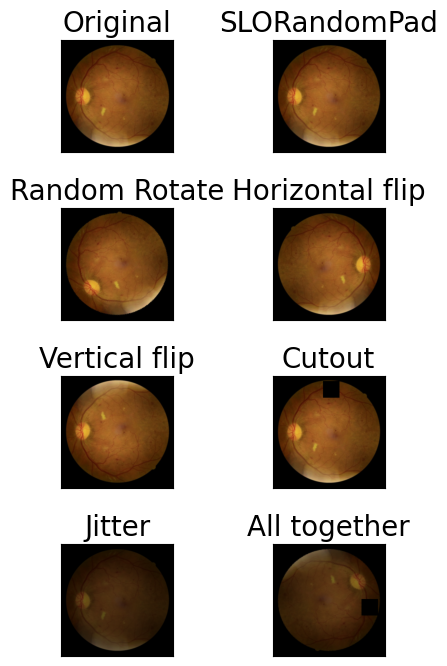

In [ ]:
# visualize
fig,axs=plt.subplots(4,2,figsize=(5,8))
axs=axs.flatten()
sample_path = 'prova.jpg'
orimg=plt.imread(sample_path)
orimg=transforms.Resize((224,224))(Image.fromarray(orimg))
orimg=np.array(orimg)

#original
axs[0].imshow(orimg)
axs[0].set_title("Original", fontsize=20)

orimg=Image.fromarray(orimg)

#slorp
axs[1].imshow(SLORandomPad((224, 224))(orimg))
axs[1].set_title("SLORandomPad", fontsize=20)

#rotate
axs[2].imshow(FundRandomRotate(prob=1.0, degree=45)(orimg))
axs[2].set_title("Random Rotate", fontsize=20)

#horflip
axs[3].imshow(transforms.RandomHorizontalFlip(p=1.0)(orimg))
axs[3].set_title("Horizontal flip", fontsize=20)

#verflip
axs[4].imshow(transforms.RandomVerticalFlip(p=1.0)(orimg))
axs[4].set_title("Vertical flip", fontsize=20)

#cutout
img=np.array(orimg)
img=transforms.ToTensor()(img)
img=CutOut(32,p=1.0)(img)
img=transforms.ToPILImage()(img)

axs[5].imshow(img)
axs[5].set_title("Cutout", fontsize=20)
#jitter
axs[6].imshow(transforms.ColorJitter(brightness=(0.3, 0.5))(orimg))
axs[6].set_title("Jitter", fontsize=20)

#all together
img=SLORandomPad((224, 224))(orimg)
img=FundRandomRotate(prob=1.0, degree=45)(img)
img=transforms.RandomHorizontalFlip(p=1.0)(img)
img=transforms.RandomVerticalFlip(p=1.0)(img)
img=transforms.ColorJitter(brightness=(0.3, 0.7))(img)

img=np.array(img)
img=transforms.ToTensor()(img)
img=CutOut(32,p=1.0)(img)
img=transforms.ToPILImage()(img)

axs[7].imshow(img)
axs[7].set_title("All together", fontsize=20)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0.5)

In [ ]:
np.array(orimg).shape

(224, 224, 3)

### Training and validation

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((210, 210)),
    SLORandomPad((224, 224)),
    FundRandomRotate(prob=0.5, degree=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.1, 0.9)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


def train_model(model, train_loader, val_loader, device, criterion, optimizer, lr_scheduler, num_epochs=25,
                checkpoint_path='model.pth'):
    best_model = model.state_dict()
    best_epoch = None
    best_val_kappa = -1.0  # Initialize the best kappa score

    train_accs=[]
    train_ks=[]
    valid_accs=[]
    valid_ks=[]
    train_losses=[]
    valid_losses=[]

    for epoch in range(1, num_epochs + 1):
        print(f'\nEpoch {epoch}/{num_epochs}')
        running_loss = []
        all_preds = []
        all_labels = []

        model.train()

        with tqdm(total=len(train_loader), desc=f'Training', unit=' batch', file=sys.stdout) as pbar:
            for images, labels in train_loader:
                if not isinstance(images, list):
                    images = images.to(device)  # single image case
                else:
                    images = [x.to(device) for x in images]  # dual images case

                labels = labels.to(device)

                optimizer.zero_grad()

                outputs = model(images)
                loss = criterion(outputs, labels.long())

                loss.backward()
                optimizer.step()

                preds = torch.argmax(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                running_loss.append(loss.item())

                pbar.set_postfix({'lr': f'{optimizer.param_groups[0]["lr"]:.1e}', 'Loss': f'{loss.item():.4f}'})
                pbar.update(1)

        lr_scheduler.step()

        epoch_loss = sum(running_loss) / len(running_loss)

        train_metrics = compute_metrics(all_preds, all_labels, per_class=True)
        kappa, accuracy, precision, recall = train_metrics[:4]

        #logging
        train_accs.append(accuracy)
        train_ks.append(kappa)
        train_losses.append(epoch_loss)

        print(f'[Train] Kappa: {kappa:.4f} Accuracy: {accuracy:.4f} '
              f'Precision: {precision:.4f} Recall: {recall:.4f} Loss: {epoch_loss:.4f}')

        if len(train_metrics) > 4:
            precision_per_class, recall_per_class = train_metrics[4:]
            for i, (precision, recall) in enumerate(zip(precision_per_class, recall_per_class)):
                print(f'[Train] Class {i}: Precision: {precision:.4f}, Recall: {recall:.4f}')

        # Evaluation on the validation set at the end of each epoch
        val_metrics,val_loss = evaluate_model(model, val_loader, device, criterion=criterion)
        val_kappa,val_accuracy, val_precision, val_recall = val_metrics[:4]
        print(f'[Val] Kappa: {val_kappa:.4f} Accuracy: {val_accuracy:.4f} '
              f'Precision: {val_precision:.4f} Recall: {val_recall:.4f}')

        #logging
        valid_accs.append(val_accuracy)
        valid_ks.append(val_kappa)
        valid_losses.append(val_loss.item())

        if val_kappa > best_val_kappa:
            best_val_kappa = val_kappa
            best_epoch = epoch
            best_model = model.state_dict()
            torch.save(best_model, checkpoint_path)

    print(f'[Val] Best kappa: {best_val_kappa:.4f}, Epoch {best_epoch}')

    return model,train_accs,train_ks,valid_accs,valid_ks, train_losses, valid_losses


def evaluate_model(model, test_loader, device,criterion=None, test_only=False, prediction_path='./test_predictions.csv'):
    model.eval()

    all_preds = []
    all_labels = []
    all_image_ids = []
    all_logits=[]

    with tqdm(total=len(test_loader), desc=f'Evaluating', unit=' batch', file=sys.stdout) as pbar:
        for i, data in enumerate(test_loader):

            if test_only:
                images = data
            else:
                images, labels = data

            if not isinstance(images, list):
                images = images.to(device)  # single image case
            else:
                images = [x.to(device) for x in images]  # dual images case

            with torch.no_grad():
                outputs = model(images)
                preds = torch.argmax(outputs, 1)

            if not isinstance(images, list):
                # single image case
                all_preds.extend(preds.cpu().numpy())
                all_logits.extend(outputs.cpu().numpy())
                image_ids = [
                    os.path.basename(test_loader.dataset.data[idx]['img_path']) for idx in
                    range(i * test_loader.batch_size, i * test_loader.batch_size + len(images))
                ]
                all_image_ids.extend(image_ids)
                if not test_only:
                    all_labels.extend(labels.numpy())
            else:
                # dual images case
                for k in range(2):
                    all_preds.extend(preds.cpu().numpy())
                    image_ids = [
                        os.path.basename(test_loader.dataset.data[idx][f'img_path{k + 1}']) for idx in
                        range(i * test_loader.batch_size, i * test_loader.batch_size + len(images[k]))
                    ]
                    all_image_ids.extend(image_ids)
                    if not test_only:
                        all_labels.extend(labels.numpy())

            pbar.update(1)

    # Save predictions to csv file for Kaggle online evaluation
    if test_only:
        df = pd.DataFrame({
            'ID': all_image_ids,
            'TARGET': all_preds
        })
        df.to_csv(prediction_path, index=False)
        print(f'[Test] Save predictions to {os.path.abspath(prediction_path)}')
    else:
        all_logits_tensor = torch.tensor(all_logits, dtype=torch.float32)  # Raw outputs
        all_labels_tensor = torch.tensor(all_labels, dtype=torch.long)  # True labels

        loss = criterion(all_logits_tensor, all_labels_tensor)
        metrics = compute_metrics(all_preds, all_labels)
        return metrics, loss


def compute_metrics(preds, labels, per_class=False):
    kappa = cohen_kappa_score(labels, preds, weights='quadratic')
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted', zero_division=0)
    recall = recall_score(labels, preds, average='weighted', zero_division=0)

    # Calculate and print precision and recall for each class
    if per_class:
        precision_per_class = precision_score(labels, preds, average=None, zero_division=0)
        recall_per_class = recall_score(labels, preds, average=None, zero_division=0)
        return kappa, accuracy, precision, recall, precision_per_class, recall_per_class

    return kappa, accuracy, precision, recall

### Models

In [ ]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Identity()  # Remove the original classification layer

        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x

class MyDualModel(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        backbone = models.resnet18(pretrained=True)
        backbone.fc = nn.Identity()

        # Here the two backbones will have the same structure but unshared weights
        self.backbone1 = copy.deepcopy(backbone)
        self.backbone2 = copy.deepcopy(backbone)

        self.fc = nn.Sequential(
            nn.Linear(512 * 2, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, images):
        image1, image2 = images

        x1 = self.backbone1(image1)
        x2 = self.backbone2(image2)

        x = torch.cat((x1, x2), dim=1)
        x = self.fc(x)
        return x

class EffNet(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        self.backbone = models.efficientnet_b0(pretrained=True)
        self.backbone.fc = nn.Identity()  # Remove the original classification layer

        self.fc = nn.Sequential(
            nn.Linear(1000, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x

class DenseNet(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        self.backbone = models.densenet121(pretrained=True)
        self.backbone.fc = nn.Identity()  # Remove the original classification layer

        self.fc = nn.Sequential(
            nn.Linear(1000, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x

### Main

In [ ]:
import matplotlib.pyplot as plt
# Choose between 'single image' and 'dual images' pipeline
# This will affect the model definition, dataset pipeline, training and evaluation

mode = 'single'  # forward single image to the model each time
# mode = 'dual'  # forward two images of the same eye to the model and fuse the features

assert mode in ('single', 'dual')

# Define the model
if mode == 'single':
    model = ResNet18()
else:
    model = MyDualModel()

print(model, '\n')
print('Pipeline Mode:', mode)

ResNet18(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def train_and_evaluate(model,transform_train,transform_valid,name,checkpoint):
  try:
    os.mkdir('./'+name)
  except:
    pass
  # Create datasets
  train_dataset = RetinopathyDataset('/content/521153S-3005-final-project/DeepDRiD/train.csv', '/content/521153S-3005-final-project/DeepDRiD/train/', transform_train, mode)
  val_dataset = RetinopathyDataset('/content/521153S-3005-final-project/DeepDRiD/val.csv', '/content/521153S-3005-final-project/DeepDRiD/val/', transform_test, mode)
  test_dataset = RetinopathyDataset('/content/521153S-3005-final-project/DeepDRiD/test.csv', '/content/521153S-3005-final-project/DeepDRiD/test/', transform_test, mode, test=True)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  # Define the weighted CrossEntropyLoss
  criterion = nn.CrossEntropyLoss()

  # Use GPU device is possible
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print('Device:', device)

  # Move class weights to the device
  model = model.to(device)

  # Optimizer and Learning rate scheduler
  optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
  lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

  # Train and evaluate the model with the training and validation set
  model,trainacc,traink,validacc,validk, trainl, validl = train_model(
      model, train_loader, val_loader, device, criterion, optimizer,
      lr_scheduler=lr_scheduler, num_epochs=num_epochs,
      checkpoint_path=checkpoint
  )


  # Load the pretrained checkpoint
  state_dict = torch.load(checkpoint, map_location='cpu')
  model.load_state_dict(state_dict, strict=True)

  # Make predictions on testing set and save the prediction results
  evaluate_model(model, test_loader, device, test_only=True,prediction_path='./'+name+'/test_predictions.csv')


  fig, axes = plt.subplots(2, 2, figsize=(8, 8))
  axes=axes.reshape(-1)

  # Plot training loss
  axes[0].plot(np.array(trainacc), label="Train Accuracy", color="blue")
  axes[0].plot(np.array(traink), label="Train Kappa", color="green")
  axes[1].plot(np.array(trainl), label="Train Loss", color="red")
  axes[0].set_title("Training metrics")
  axes[0].set_xlabel("Epochs")
  axes[1].set_title("Training loss")
  axes[1].set_xlabel("Epochs")
  axes[0].legend()
  axes[0].grid(True)
  axes[1].legend()
  axes[1].grid(True)
  axes[0].set_ylim(0, 1)

  # Plot validation loss
  axes[2].plot(np.array(validacc), label="Validation Accuracy", color="blue")
  axes[2].plot(np.array(validk), label="Validation Kappa", color="green")
  axes[3].plot(np.array(validl), label="Validation Loss", color="red")
  axes[2].set_title("Validation metrics")
  axes[2].set_xlabel("Epochs")
  axes[3].set_title("Validation loss")
  axes[3].set_xlabel("Epochs")
  axes[2].legend()
  axes[2].grid(True)
  axes[3].legend()
  axes[3].grid(True)
  axes[2].set_ylim(0, 1)

  # Adjust layout
  plt.tight_layout()
  plt.show()
  return model

### WITHOUT AUGMENTATION

Device: cuda

Epoch 1/15
Training: 100%|██████████| 38/38 [00:10<00:00,  3.79 batch/s, lr=1.0e-03, Loss=1.2352]
[Train] Kappa: 0.5268 Accuracy: 0.4367 Precision: 0.4055 Recall: 0.4367 Loss: 1.3255
[Train] Class 0: Precision: 0.7130, Recall: 0.8694
[Train] Class 1: Precision: 0.2523, Recall: 0.2250
[Train] Class 2: Precision: 0.2698, Recall: 0.2833
[Train] Class 3: Precision: 0.3043, Recall: 0.3500
[Train] Class 4: Precision: 0.2632, Recall: 0.0417
Evaluating: 100%|██████████| 13/13 [00:02<00:00,  5.84 batch/s]
[Val] Kappa: 0.2254 Accuracy: 0.3925 Precision: 0.2954 Recall: 0.3925

Epoch 2/15
Training: 100%|██████████| 38/38 [00:09<00:00,  3.80 batch/s, lr=1.0e-03, Loss=1.1560]
[Train] Kappa: 0.6326 Accuracy: 0.5025 Precision: 0.4571 Recall: 0.5025 Loss: 1.1759
[Train] Class 0: Precision: 0.7908, Recall: 0.9556
[Train] Class 1: Precision: 0.3405, Recall: 0.3292
[Train] Class 2: Precision: 0.2326, Recall: 0.1667
[Train] Class 3: Precision: 0.3931, Recall: 0.5667
[Train] Class 4: Precision

<ipython-input-49-1213c203a0b5>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint, map_location='cpu')


[Val] Best kappa: 0.7916, Epoch 15
Evaluating: 100%|██████████| 13/13 [00:02<00:00,  4.41 batch/s]
[Test] Save predictions to /content/noaug.pth/test_predictions.csv


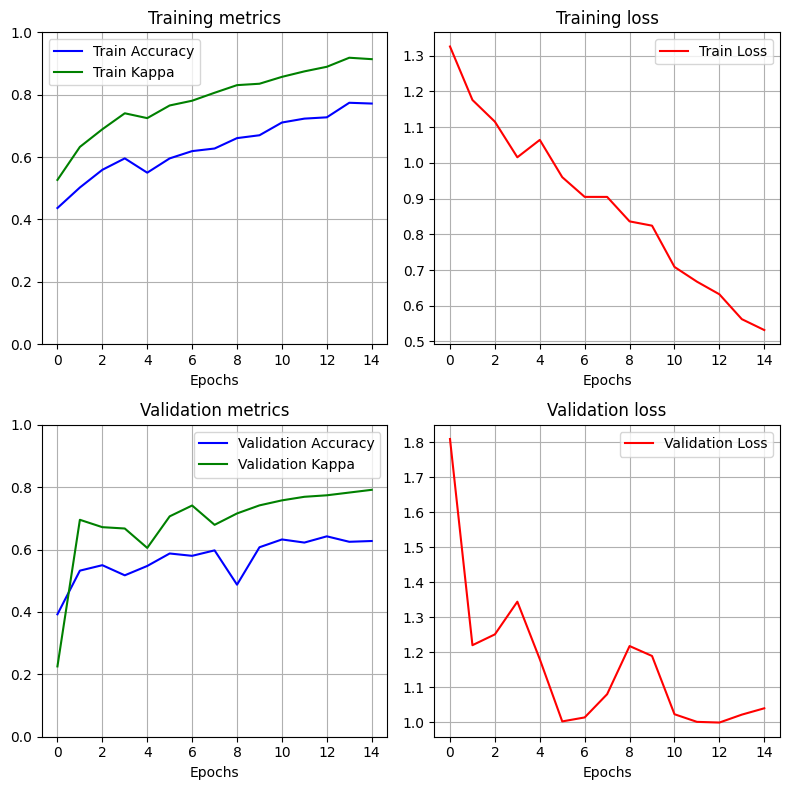

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

name='noaug.pth'
model = ResNet18()
model=train_and_evaluate(model,transform_train,transform_test,name,f'./{name}/{name}')
#torch.save(model.state_dict(),f'./{name}/{name}')

WITH SLORP

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Device: cuda

Epoch 1/15
Training: 100%|██████████| 38/38 [00:11<00:00,  3.34 batch/s, lr=1.0e-03, Loss=1.0394]
[Train] Kappa: 0.5388 Accuracy: 0.4700 Precision: 0.4502 Recall: 0.4700 Loss: 1.2839
[Train] Class 0: Precision: 0.7361, Recall: 0.8833
[Train] Class 1: Precision: 0.3153, Recall: 0.3875
[Train] Class 2: Precision: 0.2562, Recall: 0.2167
[Train] Class 3: Precision: 0.3710, Recall: 0.3833
[Train] Class 4: Precision: 0.4091, Recall: 0.0750
Evaluating: 100%|██████████| 13/13 [00:02<00:00,  5.82 batch/s]
[Val] Kappa: 0.6386 Accuracy: 0.5500 Precision: 0.5179 Recall: 0.5500

Epoch 2/15
Training: 100%|██████████| 38/38 [00:11<00:00,  3.36 batch/s, lr=1.0e-03, Loss=0.9584]
[Train] Kappa: 0.6080 Accuracy: 0.5017 Precision: 0.4793 Recall: 0.5017 Loss: 1.1888
[Train] Class 0: Precision: 0.7968, Recall: 0.9583
[Train] Class 1: Precision: 0.3198, Recall: 0.2958
[Train] Class 2: Precision: 0.2930, Recall: 0.3333
[Train] Class 3: Precision: 0.3884, Recall: 0.3917
[Train] Class 4: Precision

<ipython-input-49-1213c203a0b5>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint, map_location='cpu')



[Val] Kappa: 0.7456 Accuracy: 0.5750 Precision: 0.4949 Recall: 0.5750
[Val] Best kappa: 0.7651, Epoch 13
Evaluating: 100%|██████████| 13/13 [00:03<00:00,  4.29 batch/s]
[Test] Save predictions to /content/slorp.pth/test_predictions.csv


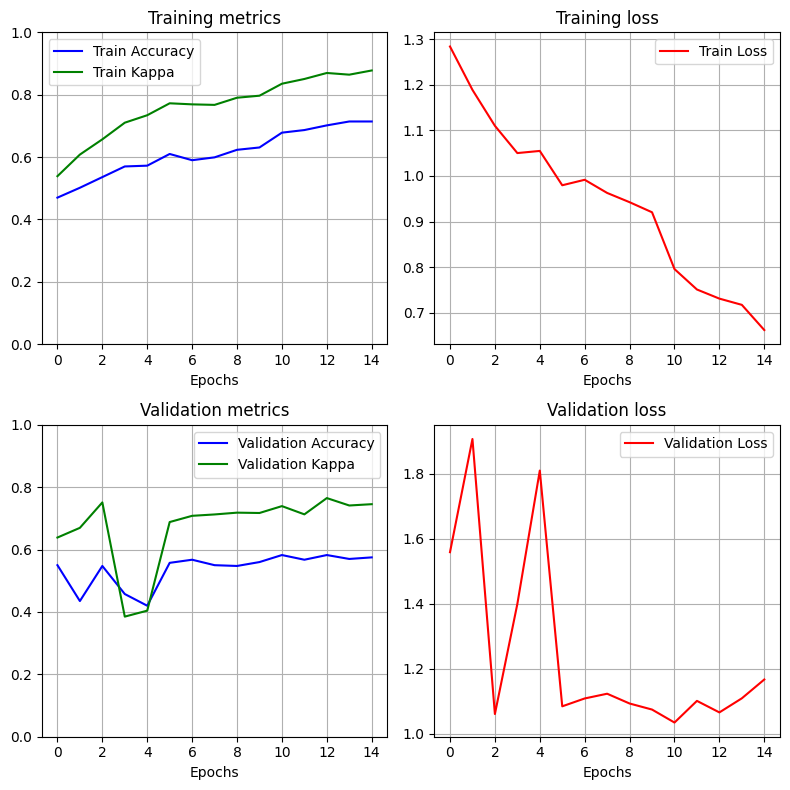

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    SLORandomPad((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


name='slorp.pth'
model = ResNet18()
model=train_and_evaluate(model,transform_train,transform_test,name,f'./{name}/{name}')
#torch.save(model.state_dict(),f'./{name}/{name}')

WITH RANDOMROTATE

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Device: cuda

Epoch 1/15
Training: 100%|██████████| 38/38 [00:11<00:00,  3.28 batch/s, lr=1.0e-03, Loss=1.2797]
[Train] Kappa: 0.5957 Accuracy: 0.4675 Precision: 0.4400 Recall: 0.4675 Loss: 1.2913
[Train] Class 0: Precision: 0.7604, Recall: 0.8639
[Train] Class 1: Precision: 0.3656, Recall: 0.2833
[Train] Class 2: Precision: 0.2482, Recall: 0.2875
[Train] Class 3: Precision: 0.3649, Recall: 0.4500
[Train] Class 4: Precision: 0.1613, Recall: 0.0417
Evaluating: 100%|██████████| 13/13 [00:02<00:00,  5.80 batch/s]
[Val] Kappa: 0.6664 Accuracy: 0.5150 Precision: 0.4164 Recall: 0.5150

Epoch 2/15
Training: 100%|██████████| 38/38 [00:11<00:00,  3.32 batch/s, lr=1.0e-03, Loss=1.4562]
[Train] Kappa: 0.6702 Accuracy: 0.5342 Precision: 0.4959 Recall: 0.5342 Loss: 1.1391
[Train] Class 0: Precision: 0.7991, Recall: 0.9389
[Train] Class 1: Precision: 0.3821, Recall: 0.4792
[Train] Class 2: Precision: 0.3121, Recall: 0.1833
[Train] Class 3: Precision: 0.4482, Recall: 0.5583
[Train] Class 4: Precision

<ipython-input-49-1213c203a0b5>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint, map_location='cpu')


[Val] Best kappa: 0.7937, Epoch 15
Evaluating: 100%|██████████| 13/13 [00:02<00:00,  5.54 batch/s]
[Test] Save predictions to /content/ranrot.pth/test_predictions.csv


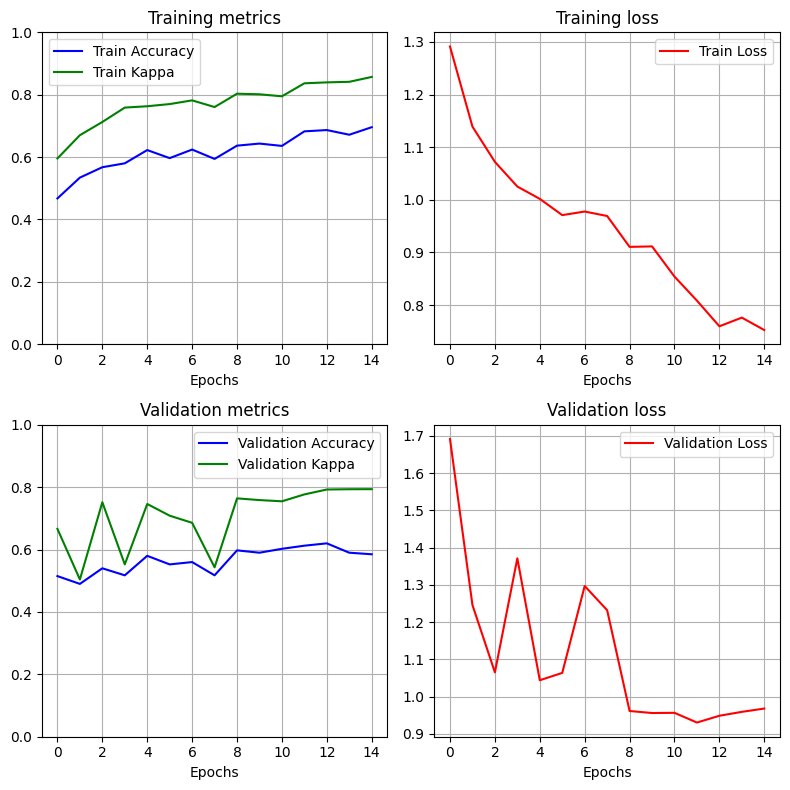

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    FundRandomRotate(prob=1.0, degree=30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


name='ranrot.pth'
model = ResNet18()
model=train_and_evaluate(model,transform_train,transform_test,name,f'./{name}/{name}')
#torch.save(model.state_dict(),f'./{name}/{name}')

WITH FLIPS

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Device: cuda

Epoch 1/15
Training: 100%|██████████| 38/38 [00:11<00:00,  3.35 batch/s, lr=1.0e-03, Loss=1.1287]
[Train] Kappa: 0.5091 Accuracy: 0.4700 Precision: 0.4009 Recall: 0.4700 Loss: 1.2923
[Train] Class 0: Precision: 0.6783, Recall: 0.9194
[Train] Class 1: Precision: 0.3333, Recall: 0.3042
[Train] Class 2: Precision: 0.2762, Recall: 0.2417
[Train] Class 3: Precision: 0.3778, Recall: 0.4250
[Train] Class 4: Precision: 0.0000, Recall: 0.0000
Evaluating: 100%|██████████| 13/13 [00:02<00:00,  5.71 batch/s]
[Val] Kappa: 0.6097 Accuracy: 0.5450 Precision: 0.4526 Recall: 0.5450

Epoch 2/15
Training: 100%|██████████| 38/38 [00:11<00:00,  3.36 batch/s, lr=1.0e-03, Loss=0.9911]
[Train] Kappa: 0.6706 Accuracy: 0.5300 Precision: 0.5009 Recall: 0.5300 Loss: 1.1495
[Train] Class 0: Precision: 0.7816, Recall: 0.9444
[Train] Class 1: Precision: 0.4213, Recall: 0.4125
[Train] Class 2: Precision: 0.3068, Recall: 0.2250
[Train] Class 3: Precision: 0.4042, Recall: 0.5625
[Train] Class 4: Precision

<ipython-input-49-1213c203a0b5>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint, map_location='cpu')



[Val] Kappa: 0.7443 Accuracy: 0.5875 Precision: 0.5159 Recall: 0.5875
[Val] Best kappa: 0.7606, Epoch 14
Evaluating: 100%|██████████| 13/13 [00:02<00:00,  4.61 batch/s]
[Test] Save predictions to /content/flips.pth/test_predictions.csv


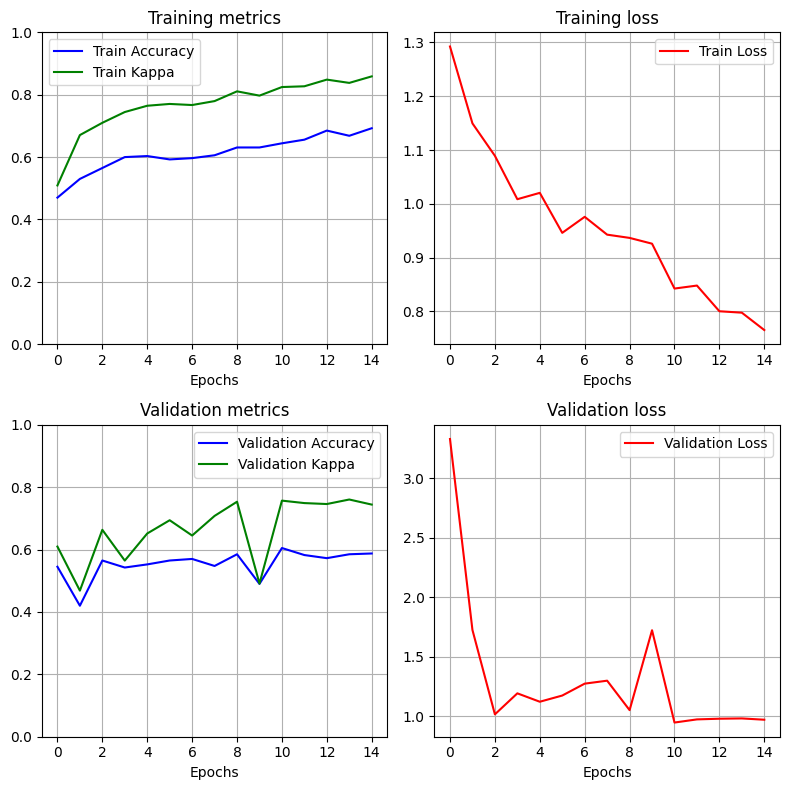

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


name='flips.pth'
model = ResNet18()
model=train_and_evaluate(model,transform_train,transform_test,name,f'./{name}/{name}')
#torch.save(model.state_dict(),f'./{name}/{name}')

WITH JITTER

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Device: cuda

Epoch 1/15
Training: 100%|██████████| 38/38 [00:11<00:00,  3.25 batch/s, lr=1.0e-04, Loss=1.3120]
[Train] Kappa: 0.4422 Accuracy: 0.4258 Precision: 0.3920 Recall: 0.4258 Loss: 1.4536
[Train] Class 0: Precision: 0.6233, Recall: 0.7444
[Train] Class 1: Precision: 0.3321, Recall: 0.3708
[Train] Class 2: Precision: 0.3182, Recall: 0.0875
[Train] Class 3: Precision: 0.3282, Recall: 0.5375
[Train] Class 4: Precision: 0.0930, Recall: 0.0333
Evaluating: 100%|██████████| 13/13 [00:02<00:00,  4.51 batch/s]
[Val] Kappa: 0.5450 Accuracy: 0.6879 Precision: 0.5450 Recall: 0.4053

Epoch 2/15
Training: 100%|██████████| 38/38 [00:12<00:00,  3.14 batch/s, lr=1.0e-04, Loss=1.1699]
[Train] Kappa: 0.6947 Accuracy: 0.5542 Precision: 0.4863 Recall: 0.5542 Loss: 1.1185
[Train] Class 0: Precision: 0.7445, Recall: 0.9472
[Train] Class 1: Precision: 0.4889, Recall: 0.4583
[Train] Class 2: Precision: 0.3154, Recall: 0.1708
[Train] Class 3: Precision: 0.4550, Recall: 0.7167
[Train] Class 4: Precision

<ipython-input-17-1213c203a0b5>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint, map_location='cpu')



[Val] Kappa: 0.6250 Accuracy: 0.7452 Precision: 0.6250 Recall: 0.5995
[Val] Best kappa: 0.6275, Epoch 5
Evaluating: 100%|██████████| 13/13 [00:03<00:00,  4.08 batch/s]
[Test] Save predictions to /content/jitter.pth/test_predictions.csv


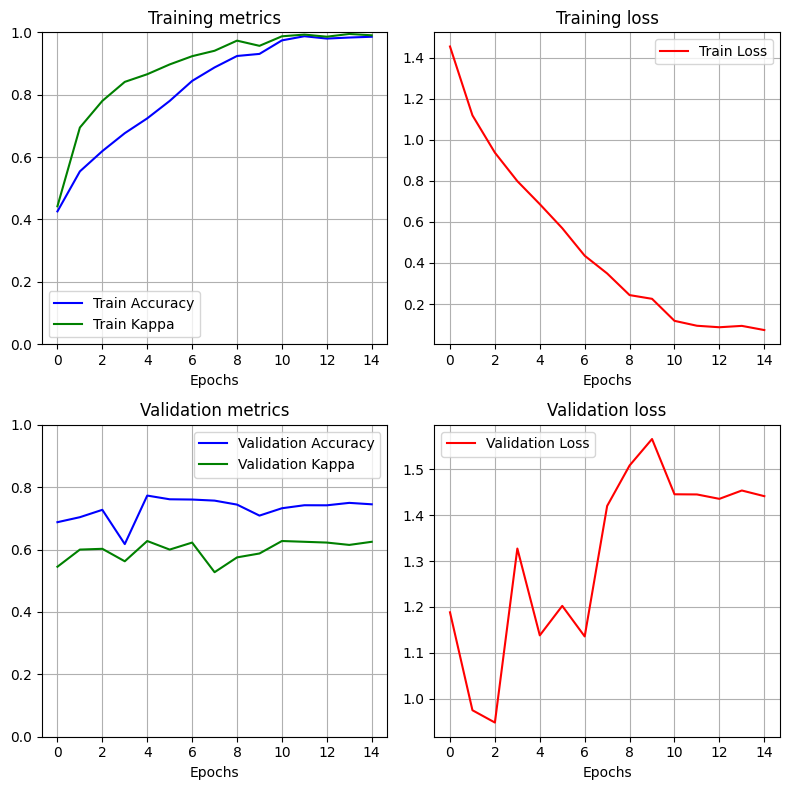

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ColorJitter(brightness=(0.1, 0.9)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


name='jitter.pth'
model = ResNet18()
model=train_and_evaluate(model,transform_train,transform_test,name,f'./{name}/{name}')
#torch.save(model.state_dict(),f'./{name}/{name}')

COMBO1

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Device: cuda

Epoch 1/15
Training: 100%|██████████| 38/38 [00:11<00:00,  3.17 batch/s, lr=1.0e-03, Loss=1.5694]
[Train] Kappa: 0.4206 Accuracy: 0.4033 Precision: 0.3603 Recall: 0.4033 Loss: 1.3940
[Train] Class 0: Precision: 0.6274, Recall: 0.8278
[Train] Class 1: Precision: 0.2530, Recall: 0.2625
[Train] Class 2: Precision: 0.2545, Recall: 0.2333
[Train] Class 3: Precision: 0.2727, Recall: 0.2625
[Train] Class 4: Precision: 0.1600, Recall: 0.0333
Evaluating: 100%|██████████| 13/13 [00:02<00:00,  4.95 batch/s]
[Val] Kappa: 0.0796 Accuracy: 0.2175 Precision: 0.3427 Recall: 0.2175

Epoch 2/15
Training: 100%|██████████| 38/38 [00:12<00:00,  3.10 batch/s, lr=1.0e-03, Loss=1.4601]
[Train] Kappa: 0.5161 Accuracy: 0.4408 Precision: 0.3907 Recall: 0.4408 Loss: 1.2767
[Train] Class 0: Precision: 0.6934, Recall: 0.9361
[Train] Class 1: Precision: 0.2617, Recall: 0.2333
[Train] Class 2: Precision: 0.2636, Recall: 0.2625
[Train] Class 3: Precision: 0.2881, Recall: 0.2833
[Train] Class 4: Precision

<ipython-input-49-1213c203a0b5>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint, map_location='cpu')


Evaluating: 100%|██████████| 13/13 [00:02<00:00,  5.35 batch/s]
[Test] Save predictions to /content/combo1.pth/test_predictions.csv


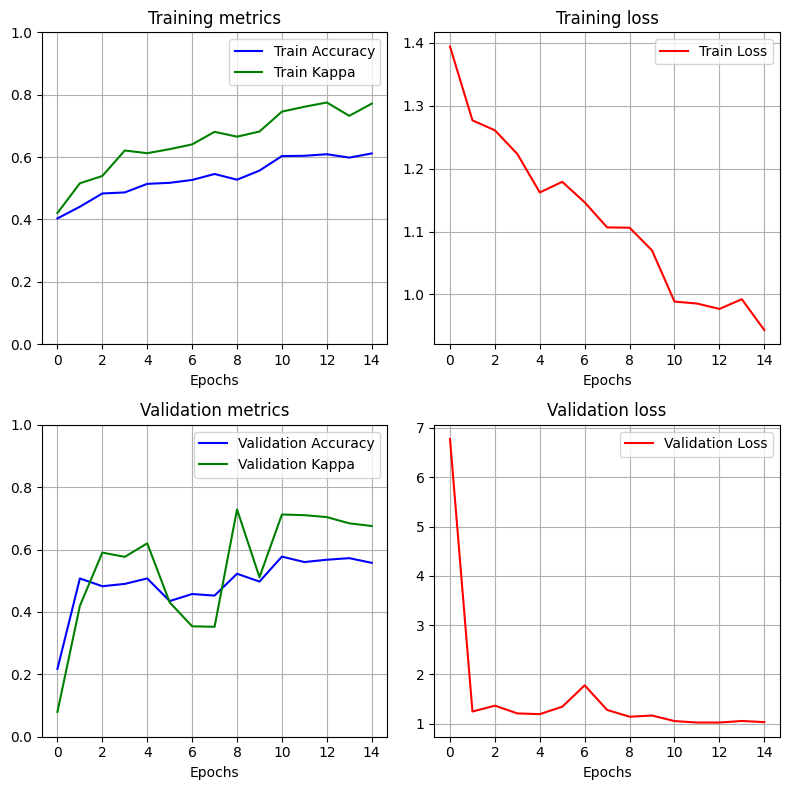

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.1, 0.9)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    CutOut(32),
    #WhiteNoise()
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


name='combo1.pth'
model = ResNet18()
model=train_and_evaluate(model,transform_train,transform_test,name,f'./{name}/{name}')
#torch.save(model.state_dict(),f'./{name}/{name}')

COMBO2

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Device: cuda

Epoch 1/15
Training: 100%|██████████| 38/38 [00:12<00:00,  3.08 batch/s, lr=1.0e-03, Loss=1.5140]
[Train] Kappa: 0.4670 Accuracy: 0.4267 Precision: 0.3884 Recall: 0.4267 Loss: 1.3885
[Train] Class 0: Precision: 0.6968, Recall: 0.7917
[Train] Class 1: Precision: 0.3197, Recall: 0.3250
[Train] Class 2: Precision: 0.2562, Recall: 0.2167
[Train] Class 3: Precision: 0.2991, Recall: 0.4000
[Train] Class 4: Precision: 0.0435, Recall: 0.0083
Evaluating: 100%|██████████| 13/13 [00:02<00:00,  5.78 batch/s]
[Val] Kappa: 0.6312 Accuracy: 0.4900 Precision: 0.4780 Recall: 0.4900

Epoch 2/15
Training: 100%|██████████| 38/38 [00:12<00:00,  3.08 batch/s, lr=1.0e-03, Loss=1.0061]
[Train] Kappa: 0.5599 Accuracy: 0.4950 Precision: 0.4457 Recall: 0.4950 Loss: 1.2323
[Train] Class 0: Precision: 0.7544, Recall: 0.9556
[Train] Class 1: Precision: 0.3846, Recall: 0.3958
[Train] Class 2: Precision: 0.3202, Recall: 0.3042
[Train] Class 3: Precision: 0.3173, Recall: 0.3292
[Train] Class 4: Precision

<ipython-input-49-1213c203a0b5>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint, map_location='cpu')



[Val] Kappa: 0.7572 Accuracy: 0.6150 Precision: 0.5364 Recall: 0.6150
[Val] Best kappa: 0.7697, Epoch 13
Evaluating: 100%|██████████| 13/13 [00:02<00:00,  5.54 batch/s]
[Test] Save predictions to /content/combo2.pth/test_predictions.csv


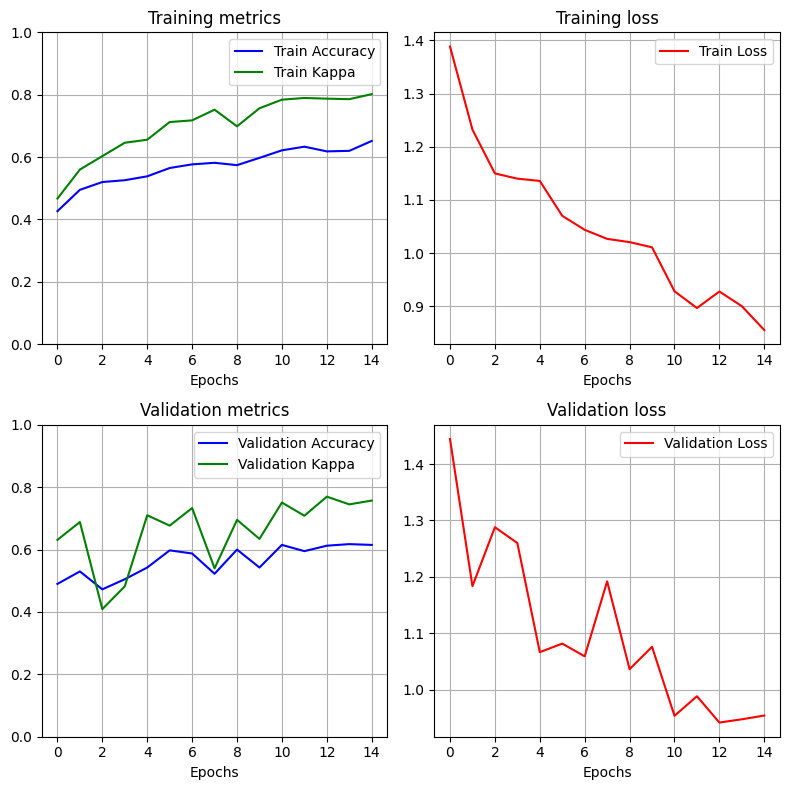

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    SLORandomPad((224, 224)),
    FundRandomRotate(prob=0.5, degree=30),
    transforms.ColorJitter(brightness=(0.1, 0.9)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    #WhiteNoise()
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


name='combo2.pth'
model = ResNet18()
model=train_and_evaluate(model,transform_train,transform_test,name,f'./{name}/{name}')
#torch.save(model.state_dict(),f'./{name}/{name}')

### WITH ALL AUGMENTATION FUNCTIONS

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Device: cuda

Epoch 1/15
Training: 100%|██████████| 38/38 [00:12<00:00,  3.03 batch/s, lr=1.0e-03, Loss=1.6306]
[Train] Kappa: 0.5191 Accuracy: 0.4550 Precision: 0.4220 Recall: 0.4550 Loss: 1.3083
[Train] Class 0: Precision: 0.7302, Recall: 0.8722
[Train] Class 1: Precision: 0.2857, Recall: 0.3667
[Train] Class 2: Precision: 0.2671, Recall: 0.1792
[Train] Class 3: Precision: 0.3640, Recall: 0.3792
[Train] Class 4: Precision: 0.1961, Recall: 0.0833
Evaluating: 100%|██████████| 13/13 [00:02<00:00,  5.23 batch/s]
[Val] Kappa: 0.5933 Accuracy: 0.4850 Precision: 0.4617 Recall: 0.4850

Epoch 2/15
Training: 100%|██████████| 38/38 [00:12<00:00,  3.04 batch/s, lr=1.0e-03, Loss=0.8949]
[Train] Kappa: 0.6575 Accuracy: 0.5133 Precision: 0.4721 Recall: 0.5133 Loss: 1.1738
[Train] Class 0: Precision: 0.7440, Recall: 0.9528
[Train] Class 1: Precision: 0.3633, Recall: 0.3708
[Train] Class 2: Precision: 0.3102, Recall: 0.2417
[Train] Class 3: Precision: 0.4462, Recall: 0.4667
[Train] Class 4: Precision

<ipython-input-49-1213c203a0b5>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint, map_location='cpu')


[Val] Best kappa: 0.7909, Epoch 15
Evaluating: 100%|██████████| 13/13 [00:02<00:00,  5.52 batch/s]
[Test] Save predictions to /content/allaugs.pth/test_predictions.csv


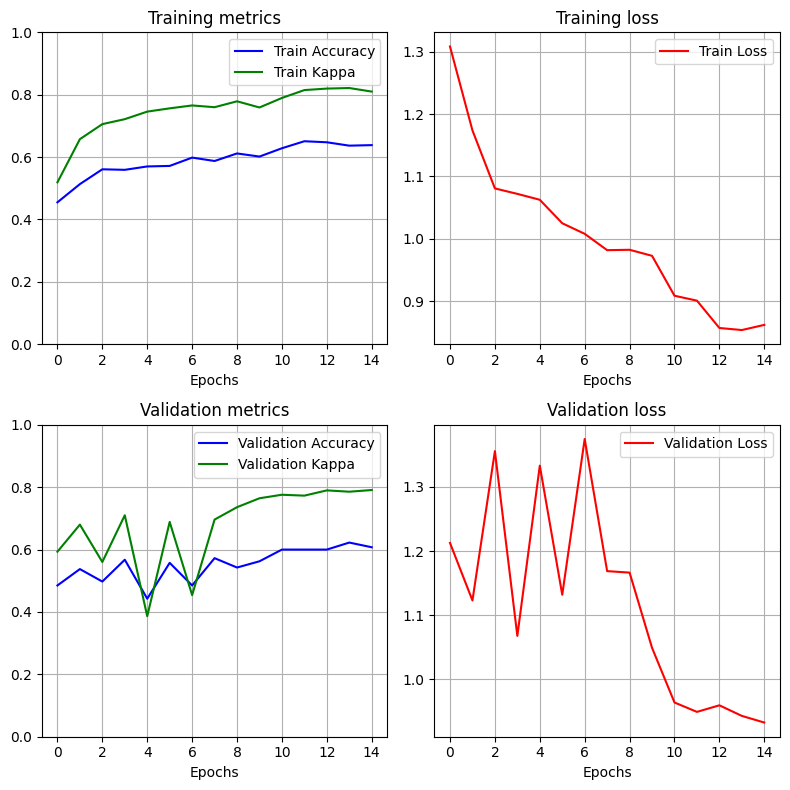

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    SLORandomPad((224, 224)),
    FundRandomRotate(prob=0.5, degree=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.3, 0.9)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    CutOut(24),
    #WhiteNoise()
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


name='allaugs.pth'
model = ResNet18()
model=train_and_evaluate(model,transform_train,transform_test,name,f'./{name}/{name}')
#torch.save(model.state_dict(),f'./{name}/{name}')

### EFFICIENT NET

WITHOUT AUGMENTATION

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Device: cuda

Epoch 1/15
Training: 100%|██████████| 38/38 [00:12<00:00,  3.16 batch/s, lr=1.0e-03, Loss=0.8344]
[Train] Kappa: 0.6000 Accuracy: 0.4958 Precision: 0.4722 Recall: 0.4958 Loss: 1.2334
[Train] Class 0: Precision: 0.7370, Recall: 0.8639
[Train] Class 1: Precision: 0.4014, Recall: 0.4750
[Train] Class 2: Precision: 0.2933, Recall: 0.1833
[Train] Class 3: Precision: 0.4245, Recall: 0.3750
[Train] Class 4: Precision: 0.2727, Recall: 0.3000
Evaluating: 100%|██████████| 13/13 [00:02<00:00,  5.54 batch/s]
[Val] Kappa: 0.7865 Accuracy: 0.6275 Precision: 0.5644 Recall: 0.6275

Epoch 2/15
Training: 100%|██████████| 38/38 [00:11<00:00,  3.17 batch/s, lr=1.0e-03, Loss=1.0527]
[Train] Kappa: 0.7987 Accuracy: 0.6333 Precision: 0.5995 Recall: 0.6333 Loss: 0.9658
[Train] Class 0: Precision: 0.8277, Recall: 0.9472
[Train] Class 1: Precision: 0.5696, Recall: 0.5625
[Train] Class 2: Precision: 0.4265, Recall: 0.3625
[Train] Class 3: Precision: 0.6013, Recall: 0.7667
[Train] Class 4: Precision

<ipython-input-49-1213c203a0b5>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint, map_location='cpu')



[Val] Kappa: 0.8222 Accuracy: 0.6700 Precision: 0.6498 Recall: 0.6700
[Val] Best kappa: 0.8256, Epoch 14
Evaluating: 100%|██████████| 13/13 [00:02<00:00,  5.11 batch/s]
[Test] Save predictions to /content/effnet_noaug.pth/test_predictions.csv


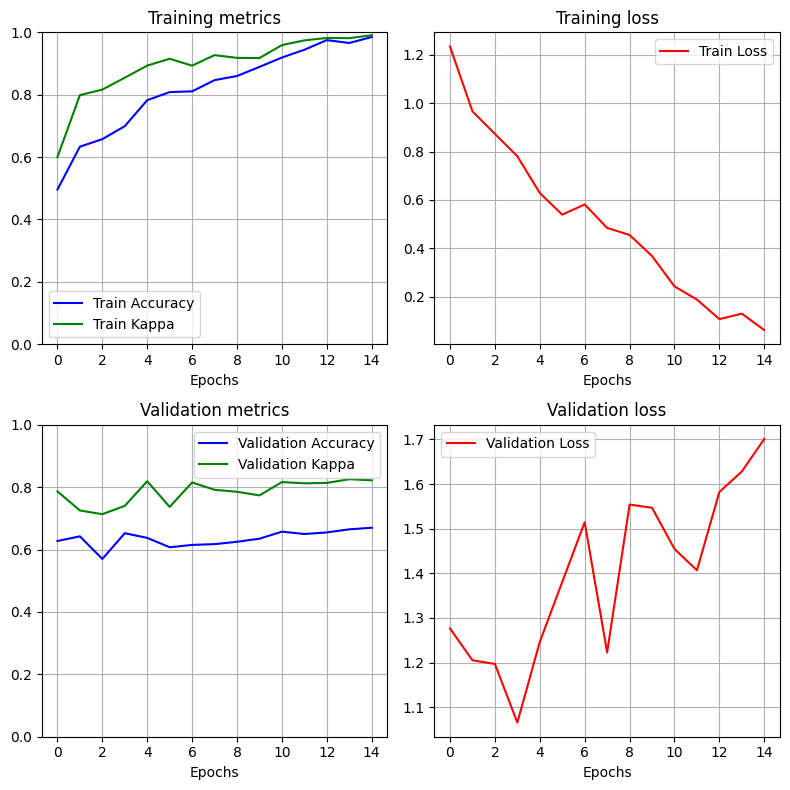

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


name='effnet_noaug.pth'
model = EffNet()
model=train_and_evaluate(model,transform_train,transform_test,name,f'./{name}/{name}')
#torch.save(model.state_dict(),f'./{name}/{name}')

WITH ALL AUGMENTATIONS

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Device: cuda

Epoch 1/15
Training: 100%|██████████| 38/38 [00:15<00:00,  2.52 batch/s, lr=1.0e-03, Loss=1.1457]
[Train] Kappa: 0.5130 Accuracy: 0.4583 Precision: 0.4012 Recall: 0.4583 Loss: 1.2856
[Train] Class 0: Precision: 0.7166, Recall: 0.8500
[Train] Class 1: Precision: 0.3229, Recall: 0.3875
[Train] Class 2: Precision: 0.2182, Recall: 0.2000
[Train] Class 3: Precision: 0.3902, Recall: 0.4292
[Train] Class 4: Precision: 0.0000, Recall: 0.0000
Evaluating: 100%|██████████| 13/13 [00:02<00:00,  4.45 batch/s]
[Val] Kappa: 0.7239 Accuracy: 0.6150 Precision: 0.5351 Recall: 0.6150

Epoch 2/15
Training: 100%|██████████| 38/38 [00:15<00:00,  2.46 batch/s, lr=1.0e-03, Loss=1.1967]
[Train] Kappa: 0.7067 Accuracy: 0.5742 Precision: 0.5473 Recall: 0.5742 Loss: 1.0815
[Train] Class 0: Precision: 0.8238, Recall: 0.9222
[Train] Class 1: Precision: 0.5364, Recall: 0.5833
[Train] Class 2: Precision: 0.3187, Recall: 0.2125
[Train] Class 3: Precision: 0.4545, Recall: 0.5833
[Train] Class 4: Precision

<ipython-input-49-1213c203a0b5>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint, map_location='cpu')



[Val] Kappa: 0.7748 Accuracy: 0.6500 Precision: 0.6205 Recall: 0.6500
[Val] Best kappa: 0.8086, Epoch 9
Evaluating: 100%|██████████| 13/13 [00:02<00:00,  5.18 batch/s]
[Test] Save predictions to /content/effnet_allaug.pth/test_predictions.csv


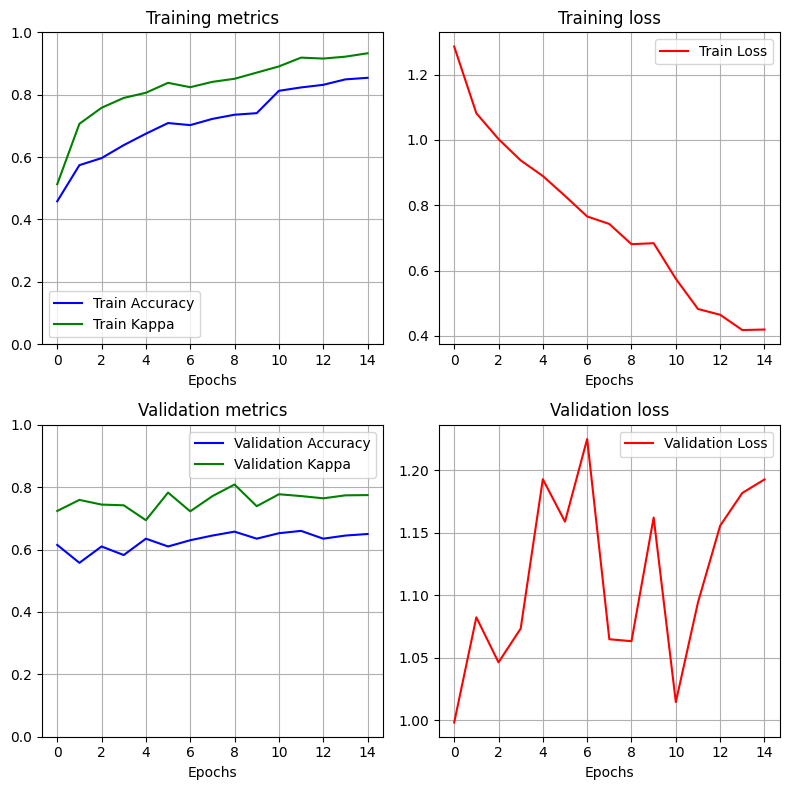

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    SLORandomPad((224, 224)),
    FundRandomRotate(prob=0.5, degree=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.3, 0.9)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    CutOut(24),
    #WhiteNoise()
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


name='effnet_allaug.pth'
model = EffNet()
model=train_and_evaluate(model,transform_train,transform_test,name,f'./{name}/{name}')
#torch.save(model.state_dict(),f'./{name}/{name}')

### DENSE NET

WITHOUT AUGMENTATION

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Device: cuda

Epoch 1/15
Training: 100%|██████████| 38/38 [00:18<00:00,  2.11 batch/s, lr=1.0e-03, Loss=1.5479]
[Train] Kappa: 0.5180 Accuracy: 0.4500 Precision: 0.4248 Recall: 0.4500 Loss: 1.3463
[Train] Class 0: Precision: 0.7014, Recall: 0.8222
[Train] Class 1: Precision: 0.3465, Recall: 0.3292
[Train] Class 2: Precision: 0.2996, Recall: 0.3208
[Train] Class 3: Precision: 0.3333, Recall: 0.3167
[Train] Class 4: Precision: 0.1846, Recall: 0.1000
Evaluating: 100%|██████████| 13/13 [00:03<00:00,  3.57 batch/s]
[Val] Kappa: 0.6195 Accuracy: 0.5425 Precision: 0.4785 Recall: 0.5425

Epoch 2/15
Training: 100%|██████████| 38/38 [00:17<00:00,  2.12 batch/s, lr=1.0e-03, Loss=1.2037]
[Train] Kappa: 0.6727 Accuracy: 0.5133 Precision: 0.4951 Recall: 0.5133 Loss: 1.1925
[Train] Class 0: Precision: 0.7918, Recall: 0.9083
[Train] Class 1: Precision: 0.4049, Recall: 0.4167
[Train] Class 2: Precision: 0.3018, Recall: 0.3458
[Train] Class 3: Precision: 0.4328, Recall: 0.3625
[Train] Class 4: Precision

<ipython-input-49-1213c203a0b5>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint, map_location='cpu')


Evaluating: 100%|██████████| 13/13 [00:03<00:00,  4.29 batch/s]
[Test] Save predictions to /content/densenet_noaug.pth/test_predictions.csv


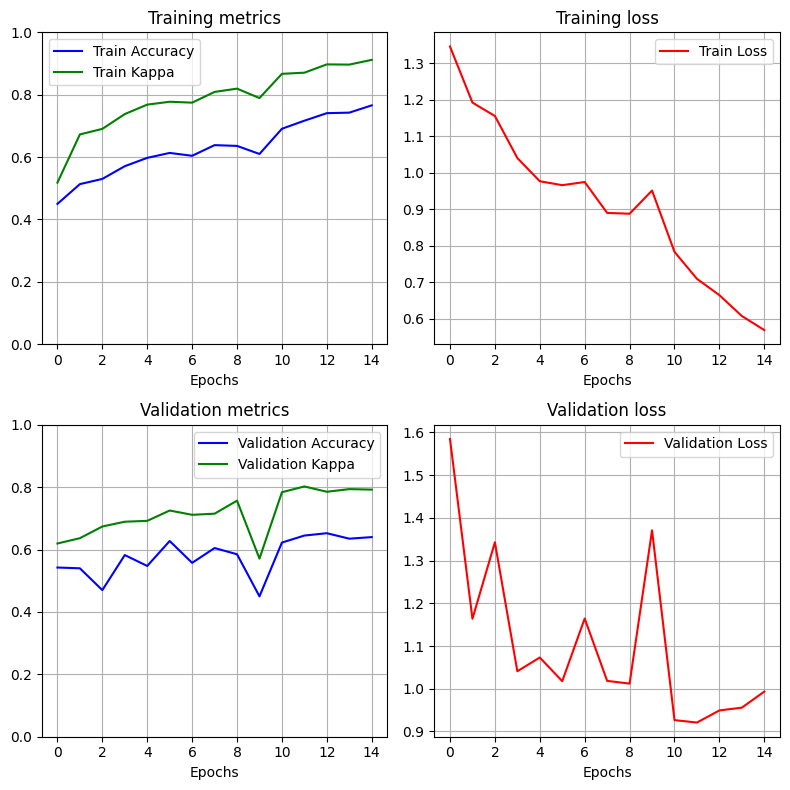

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


name='densenet_noaug.pth'
model = DenseNet()
model=train_and_evaluate(model,transform_train,transform_test,name,f'./{name}/{name}')
#torch.save(model.state_dict(),f'./{name}/{name}')

WITH ALL AUGMENTATION

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Device: cuda

Epoch 1/15
Training: 100%|██████████| 38/38 [00:22<00:00,  1.66 batch/s, lr=1.0e-03, Loss=1.3107]
[Train] Kappa: 0.4993 Accuracy: 0.4750 Precision: 0.4497 Recall: 0.4750 Loss: 1.3220
[Train] Class 0: Precision: 0.7073, Recall: 0.8389
[Train] Class 1: Precision: 0.3645, Recall: 0.3250
[Train] Class 2: Precision: 0.3036, Recall: 0.2833
[Train] Class 3: Precision: 0.3808, Recall: 0.4458
[Train] Class 4: Precision: 0.2778, Recall: 0.1250
Evaluating: 100%|██████████| 13/13 [00:03<00:00,  4.18 batch/s]
[Val] Kappa: 0.0770 Accuracy: 0.3025 Precision: 0.1246 Recall: 0.3025

Epoch 2/15
Training: 100%|██████████| 38/38 [00:22<00:00,  1.66 batch/s, lr=1.0e-03, Loss=1.3046]
[Train] Kappa: 0.6313 Accuracy: 0.5125 Precision: 0.4749 Recall: 0.5125 Loss: 1.1929
[Train] Class 0: Precision: 0.7707, Recall: 0.9056
[Train] Class 1: Precision: 0.4105, Recall: 0.3917
[Train] Class 2: Precision: 0.2971, Recall: 0.2167
[Train] Class 3: Precision: 0.4130, Recall: 0.5542
[Train] Class 4: Precision

<ipython-input-49-1213c203a0b5>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint, map_location='cpu')


Evaluating: 100%|██████████| 13/13 [00:03<00:00,  4.21 batch/s]
[Test] Save predictions to /content/densenet_allaug.pth/test_predictions.csv


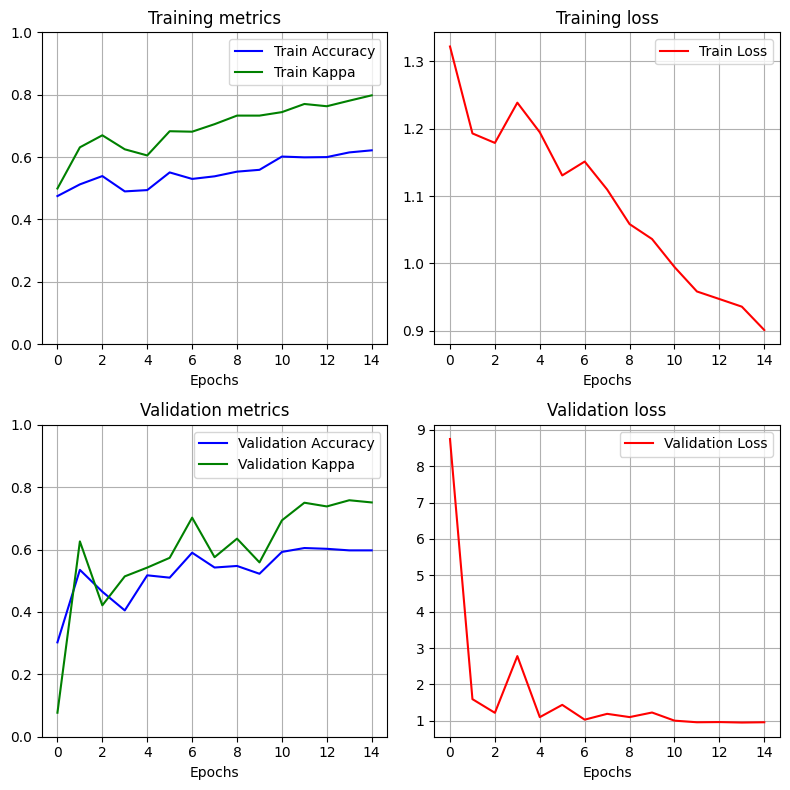

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    SLORandomPad((224, 224)),
    FundRandomRotate(prob=0.5, degree=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.3, 0.9)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    CutOut(24),
    #WhiteNoise()
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


name='densenet_allaug.pth'
model = DenseNet()
model=train_and_evaluate(model,transform_train,transform_test,name,f'./{name}/{name}')
#torch.save(model.state_dict(),f'./{name}/{name}')

WITH APTOS 2019 DATASET

In [ ]:
def train_and_evaluate(model,transform_train,transform_valid,name,checkpoint):
  try:
    os.mkdir('./'+name)
  except:
    pass
  # Create datasets
  train_dataset = RetinopathyDataset('/content/521153S-3005-final-project/DeepDRiD/train.csv', '/content/521153S-3005-final-project/DeepDRiD/train/', transform_train, mode)
  val_dataset = RetinopathyDataset('/content/521153S-3005-final-project/DeepDRiD/val.csv', '/content/521153S-3005-final-project/DeepDRiD/val/', transform_test, mode)
  test_dataset = RetinopathyDataset('/content/521153S-3005-final-project/DeepDRiD/test.csv', '/content/521153S-3005-final-project/DeepDRiD/test/', transform_test, mode, test=True)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  # Define the weighted CrossEntropyLoss
  criterion = nn.CrossEntropyLoss()

  # Use GPU device is possible
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print('Device:', device)

  # Move class weights to the device
  model = model.to(device)

  # Optimizer and Learning rate scheduler
  optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
  lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

  # Train and evaluate the model with the training and validation set
  model,trainacc,traink,validacc,validk, trainl, validl = train_model(
      model, train_loader, val_loader, device, criterion, optimizer,
      lr_scheduler=lr_scheduler, num_epochs=num_epochs,
      checkpoint_path=checkpoint
  )


  # Load the pretrained checkpoint
  state_dict = torch.load(checkpoint, map_location='cpu')
  model.load_state_dict(state_dict, strict=True)

  fig, axes = plt.subplots(2, 2, figsize=(8, 8))
  axes=axes.reshape(-1)

  # Plot training loss
  axes[0].plot(np.array(trainacc), label="Train Accuracy", color="blue")
  axes[0].plot(np.array(traink), label="Train Kappa", color="green")
  axes[1].plot(np.array(trainl), label="Train Loss", color="red")
  axes[0].set_title("Training metrics")
  axes[0].set_xlabel("Epochs")
  axes[1].set_title("Training loss")
  axes[1].set_xlabel("Epochs")
  axes[0].legend()
  axes[0].grid(True)
  axes[1].legend()
  axes[1].grid(True)
  axes[0].set_ylim(0, 1)

  # Plot validation loss
  axes[2].plot(np.array(validacc), label="Validation Accuracy", color="blue")
  axes[2].plot(np.array(validk), label="Validation Kappa", color="green")
  axes[3].plot(np.array(validl), label="Validation Loss", color="red")
  axes[2].set_title("Validation metrics")
  axes[2].set_xlabel("Epochs")
  axes[3].set_title("Validation loss")
  axes[3].set_xlabel("Epochs")
  axes[2].legend()
  axes[2].grid(True)
  axes[3].legend()
  axes[3].grid(True)
  axes[2].set_ylim(0, 1)

  # Adjust layout
  plt.tight_layout()
  plt.show()
  return model

In [ ]:
! kaggle datasets download mariaherrerot/aptos2019

Dataset URL: https://www.kaggle.com/datasets/mariaherrerot/aptos2019
License(s): unknown
100% 8.00G/8.01G [01:28<00:00, 108MB/s]
100% 8.01G/8.01G [01:28<00:00, 97.1MB/s]


In [ ]:
import zipfile

zip_path = "/content/aptos2019.zip"

extract_path = "/content/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref :
    zip_ref.extractall(extract_path)

print("Files extracted to:", extract_path)
print(os.listdir(extract_path))

Files extracted to: /content/
['.config', 'test.csv', 'val_images', 'train_1.csv', 'release', 'aptos2019.zip', 'train_images', 'test_images', '521153S-3005-final-project', '521153S-3005-final-project.zip', 'valid.csv', 'sample_data']


In [ ]:
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class APTOSDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None, file_extension='.png'):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform
        self.file_extension = file_extension
        #Store the image paths and labels as lists for easy access
        self.image_paths = self.data['id_code'].tolist()  # Assuming 'id_code' is the image column
        self.labels = self.data['diagnosis'].tolist()    # Assuming 'diagnosis' is the label column


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get image name and label using the stored lists
        img_name = os.path.join(self.image_dir, self.image_paths[idx] + self.file_extension)
        image = Image.open(img_name).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    SLORandomPad((224, 224)),
    FundRandomRotate(prob=0.5, degree=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.3, 0.9)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    CutOut(24),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = APTOSDataset(csv_file='train_1.csv', image_dir='./train_images/train_images/', transform=transform_train)
val_dataset = APTOSDataset(csv_file='valid.csv', image_dir='./val_images/val_images/', transform=transform_test)
test_dataset = APTOSDataset(csv_file='test.csv', image_dir='./test_images/test_images/', transform=transform_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
def evaluate_model(model, test_loader, device, test_only=False, criterion=None, prediction_path='./test_predictions.csv'):
    model.eval()

    all_preds = []
    all_labels = []
    all_image_ids = []
    all_logits=[]

    with tqdm(total=len(test_loader), desc=f'Evaluating', unit=' batch', file=sys.stdout) as pbar:
        for i, data in enumerate(test_loader):

            if test_only:
                images = data
            else:
                images, labels = data

            if not isinstance(images, list):
                images = images.to(device)  # single image case
            else:
                images = [x.to(device) for x in images]  # dual images case

            with torch.no_grad():
                outputs = model(images)
                preds = torch.argmax(outputs, 1)

            if not isinstance(images, list):
                # single image case
                all_preds.extend(preds.cpu().numpy())
                all_logits.extend(outputs.cpu().numpy())
                # Update to use image_paths from the dataset
                image_ids = [
                    test_loader.dataset.image_paths[idx] for idx in
                    range(i * test_loader.batch_size, min((i + 1) * test_loader.batch_size, len(test_loader.dataset)))
                ]
                all_image_ids.extend(image_ids)
                if not test_only:
                    all_labels.extend(labels.numpy())
            else:
                # dual images case (You might need to adjust this part if you use dual images with APTOSDataset)
                for k in range(2):
                    all_preds.extend(preds.cpu().numpy())
                    # Update to use image_paths from the dataset
                    image_ids = [
                        test_loader.dataset.image_paths[idx] for idx in
                        range(i * test_loader.batch_size, min((i + 1) * test_loader.batch_size, len(test_loader.dataset)))
                    ]
                    all_image_ids.extend(image_ids)
                    if not test_only:
                        all_labels.extend(labels.numpy())

            pbar.update(1)

    # Save predictions to csv file for Kaggle online evaluation
    if test_only:
        df = pd.DataFrame({
            'ID': all_image_ids,
            'TARGET': all_preds
        })
        df.to_csv(prediction_path, index=False)
        print(f'[Test] Save predictions to {os.path.abspath(prediction_path)}')
    else:
        all_logits_tensor = torch.tensor(all_logits, dtype=torch.float32)  # Raw outputs
        all_labels_tensor = torch.tensor(all_labels, dtype=torch.long)  # True labels

        loss = criterion(all_logits_tensor, all_labels_tensor)
        metrics = compute_metrics(all_preds, all_labels)
        return metrics, loss

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18(num_classes=5).to(device)



print('Device:', device)
model = model.to(device)
#unfreeze backbone layers
for param in model.backbone.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


num_epochs = 5
model, train_accs, train_ks, valid_accs, valid_ks = train_model(
    model, train_loader, val_loader, device, criterion, optimizer, lr_scheduler, num_epochs
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Device: cuda

Epoch 1/5
Training: 100%|██████████| 92/92 [06:08<00:00,  4.00s/ batch, lr=1.0e-04, Loss=0.7962]
[Train] Kappa: 0.6124 Accuracy: 0.6669 Precision: 0.5697 Recall: 0.6669 Loss: 0.9694
[Train] Class 0: Precision: 0.8235, Recall: 0.9240
[Train] Class 1: Precision: 0.0440, Recall: 0.0133
[Train] Class 2: Precision: 0.5305, Recall: 0.7636
[Train] Class 3: Precision: 0.1176, Recall: 0.0260
[Train] Class 4: Precision: 0.1212, Recall: 0.0171
Evaluating: 100%|██████████| 12/12 [00:48<00:00,  4.05s/ batch]

<ipython-input-20-19b9daa96268>:62: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  all_logits_tensor = torch.tensor(all_logits, dtype=torch.float32)  # Raw outputs



[Val] Kappa: 0.7213 Accuracy: 0.7318 Precision: 0.7213 Recall: 0.5632

Epoch 2/5
Training: 100%|██████████| 92/92 [06:08<00:00,  4.00s/ batch, lr=1.0e-04, Loss=0.5692]
[Train] Kappa: 0.7751 Accuracy: 0.7478 Precision: 0.7042 Recall: 0.7478 Loss: 0.6812
[Train] Class 0: Precision: 0.9320, Recall: 0.9749
[Train] Class 1: Precision: 0.5161, Recall: 0.2133
[Train] Class 2: Precision: 0.5633, Recall: 0.8923
[Train] Class 3: Precision: 0.2222, Recall: 0.0130
[Train] Class 4: Precision: 0.3529, Recall: 0.0256
Evaluating: 100%|██████████| 12/12 [00:48<00:00,  4.08s/ batch]
[Val] Kappa: 0.7705 Accuracy: 0.7835 Precision: 0.7705 Recall: 0.6810

Epoch 3/5
Training: 100%|██████████| 92/92 [06:10<00:00,  4.03s/ batch, lr=1.0e-04, Loss=0.8040]
[Train] Kappa: 0.8111 Accuracy: 0.7666 Precision: 0.7341 Recall: 0.7666 Loss: 0.6064
[Train] Class 0: Precision: 0.9571, Recall: 0.9791
[Train] Class 1: Precision: 0.5622, Recall: 0.3767
[Train] Class 2: Precision: 0.5998, Recall: 0.8589
[Train] Class 3: Prec

ValueError: too many values to unpack (expected 5)

In [ ]:
def evaluate_model(model, test_loader, device,criterion=None, test_only=False, prediction_path='./test_predictions.csv'):
    model.eval()

    all_preds = []
    all_labels = []
    all_image_ids = []
    all_logits=[]

    with tqdm(total=len(test_loader), desc=f'Evaluating', unit=' batch', file=sys.stdout) as pbar:
        for i, data in enumerate(test_loader):

            if test_only:
                images = data
            else:
                images, labels = data

            if not isinstance(images, list):
                images = images.to(device)  # single image case
            else:
                images = [x.to(device) for x in images]  # dual images case

            with torch.no_grad():
                outputs = model(images)
                preds = torch.argmax(outputs, 1)

            if not isinstance(images, list):
                # single image case
                all_preds.extend(preds.cpu().numpy())
                all_logits.extend(outputs.cpu().numpy())
                image_ids = [
                    os.path.basename(test_loader.dataset.data[idx]['img_path']) for idx in
                    range(i * test_loader.batch_size, i * test_loader.batch_size + len(images))
                ]
                all_image_ids.extend(image_ids)
                if not test_only:
                    all_labels.extend(labels.numpy())
            else:
                # dual images case
                for k in range(2):
                    all_preds.extend(preds.cpu().numpy())
                    image_ids = [
                        os.path.basename(test_loader.dataset.data[idx][f'img_path{k + 1}']) for idx in
                        range(i * test_loader.batch_size, i * test_loader.batch_size + len(images[k]))
                    ]
                    all_image_ids.extend(image_ids)
                    if not test_only:
                        all_labels.extend(labels.numpy())

            pbar.update(1)

    # Save predictions to csv file for Kaggle online evaluation
    if test_only:
        df = pd.DataFrame({
            'ID': all_image_ids,
            'TARGET': all_preds
        })
        df.to_csv(prediction_path, index=False)
        print(f'[Test] Save predictions to {os.path.abspath(prediction_path)}')
    else:
        all_logits_tensor = torch.tensor(all_logits, dtype=torch.float32)  # Raw outputs
        all_labels_tensor = torch.tensor(all_labels, dtype=torch.long)  # True labels

        loss = criterion(all_logits_tensor, all_labels_tensor)
        metrics = compute_metrics(all_preds, all_labels)
        return metrics, loss

In [ ]:
model=ResNet18()
statedict=torch.load('aptos_resnet.pth')
model.load_state_dict(statedict)
#unfreeze backbone layers
for param in model.backbone.parameters():
    param.requires_grad = True

<ipython-input-12-04828db1f4c9>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  statedict=torch.load('aptos_resnet.pth')


Device: cuda

Epoch 1/15
Training: 100%|██████████| 38/38 [00:10<00:00,  3.63 batch/s, lr=1.0e-04, Loss=1.3599]
[Train] Kappa: 0.5495 Accuracy: 0.4033 Precision: 0.4099 Recall: 0.4033 Loss: 1.6555
[Train] Class 0: Precision: 0.5330, Recall: 0.6722
[Train] Class 1: Precision: 0.3476, Recall: 0.3042
[Train] Class 2: Precision: 0.2470, Recall: 0.3417
[Train] Class 3: Precision: 0.5079, Recall: 0.2667
[Train] Class 4: Precision: 0.2949, Recall: 0.1917
Evaluating: 100%|██████████| 13/13 [00:02<00:00,  5.52 batch/s]

<ipython-input-8-d56e859da6fa>:168: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  all_logits_tensor = torch.tensor(all_logits, dtype=torch.float32)  # Raw outputs



[Val] Kappa: 0.5798 Accuracy: 0.4575 Precision: 0.4226 Recall: 0.4575

Epoch 2/15
Training: 100%|██████████| 38/38 [00:09<00:00,  4.12 batch/s, lr=1.0e-04, Loss=1.4392]
[Train] Kappa: 0.5581 Accuracy: 0.4408 Precision: 0.4456 Recall: 0.4408 Loss: 1.3622
[Train] Class 0: Precision: 0.5875, Recall: 0.5222
[Train] Class 1: Precision: 0.3434, Recall: 0.4250
[Train] Class 2: Precision: 0.2897, Recall: 0.3042
[Train] Class 3: Precision: 0.5099, Recall: 0.6458
[Train] Class 4: Precision: 0.4074, Recall: 0.0917
Evaluating: 100%|██████████| 13/13 [00:02<00:00,  5.60 batch/s]
[Val] Kappa: 0.6043 Accuracy: 0.4800 Precision: 0.4304 Recall: 0.4800

Epoch 3/15
Training: 100%|██████████| 38/38 [00:09<00:00,  4.19 batch/s, lr=1.0e-04, Loss=1.1054]
[Train] Kappa: 0.5772 Accuracy: 0.4475 Precision: 0.4221 Recall: 0.4475 Loss: 1.3076
[Train] Class 0: Precision: 0.5662, Recall: 0.6056
[Train] Class 1: Precision: 0.3695, Recall: 0.3833
[Train] Class 2: Precision: 0.2811, Recall: 0.2542
[Train] Class 3: Pr

<ipython-input-11-1213c203a0b5>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint, map_location='cpu')



[Val] Kappa: 0.6795 Accuracy: 0.5750 Precision: 0.5077 Recall: 0.5750
[Val] Best kappa: 0.7002, Epoch 10
Evaluating: 100%|██████████| 13/13 [00:02<00:00,  5.62 batch/s]
[Test] Save predictions to /content/finetuned_resnet.pth/test_predictions.csv


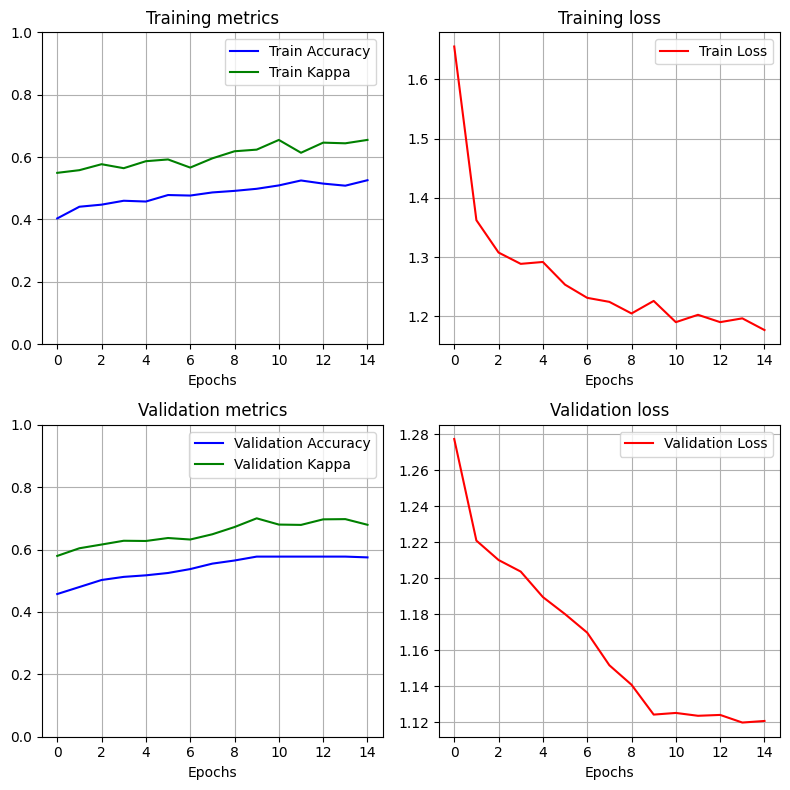

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    SLORandomPad((224, 224)),
    FundRandomRotate(prob=0.5, degree=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.3, 0.9)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    CutOut(24),
    #WhiteNoise()
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

num_epochs=15
name='finetuned_resnet.pth'
model=train_and_evaluate(model,transform_train,transform_test,name,f'./{name}/{name}')
#torch.save(model.state_dict(),f'./{name}/{name}')

### WITH EFFICIENTNET

In [ ]:
def evaluate_model(model, test_loader, device, test_only=False, criterion=None, prediction_path='./test_predictions.csv'):
    model.eval()

    all_preds = []
    all_labels = []
    all_image_ids = []
    all_logits=[]

    with tqdm(total=len(test_loader), desc=f'Evaluating', unit=' batch', file=sys.stdout) as pbar:
        for i, data in enumerate(test_loader):

            if test_only:
                images = data
            else:
                images, labels = data

            if not isinstance(images, list):
                images = images.to(device)  # single image case
            else:
                images = [x.to(device) for x in images]  # dual images case

            with torch.no_grad():
                outputs = model(images)
                preds = torch.argmax(outputs, 1)

            if not isinstance(images, list):
                # single image case
                all_preds.extend(preds.cpu().numpy())
                all_logits.extend(outputs.cpu().numpy())
                # Update to use image_paths from the dataset
                image_ids = [
                    test_loader.dataset.image_paths[idx] for idx in
                    range(i * test_loader.batch_size, min((i + 1) * test_loader.batch_size, len(test_loader.dataset)))
                ]
                all_image_ids.extend(image_ids)
                if not test_only:
                    all_labels.extend(labels.numpy())
            else:
                # dual images case (You might need to adjust this part if you use dual images with APTOSDataset)
                for k in range(2):
                    all_preds.extend(preds.cpu().numpy())
                    # Update to use image_paths from the dataset
                    image_ids = [
                        test_loader.dataset.image_paths[idx] for idx in
                        range(i * test_loader.batch_size, min((i + 1) * test_loader.batch_size, len(test_loader.dataset)))
                    ]
                    all_image_ids.extend(image_ids)
                    if not test_only:
                        all_labels.extend(labels.numpy())

            pbar.update(1)

    # Save predictions to csv file for Kaggle online evaluation
    if test_only:
        df = pd.DataFrame({
            'ID': all_image_ids,
            'TARGET': all_preds
        })
        df.to_csv(prediction_path, index=False)
        print(f'[Test] Save predictions to {os.path.abspath(prediction_path)}')
    else:
        all_logits_tensor = torch.tensor(all_logits, dtype=torch.float32)  # Raw outputs
        all_labels_tensor = torch.tensor(all_labels, dtype=torch.long)  # True labels

        loss = criterion(all_logits_tensor, all_labels_tensor)
        metrics = compute_metrics(all_preds, all_labels)
        return metrics, loss

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EffNet(num_classes=5).to(device)



print('Device:', device)
model = model.to(device)
#unfreeze backbone layers
for param in model.backbone.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


num_epochs = 5
train_model(
    model, train_loader, val_loader, device, criterion, optimizer, lr_scheduler, num_epochs
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 69.9MB/s]


Device: cuda

Epoch 1/5
Training: 100%|██████████| 92/92 [06:36<00:00,  4.31s/ batch, lr=1.0e-04, Loss=0.9985]
[Train] Kappa: 0.5175 Accuracy: 0.5990 Precision: 0.5693 Recall: 0.5990 Loss: 1.1070
[Train] Class 0: Precision: 0.8114, Recall: 0.8368
[Train] Class 1: Precision: 0.1379, Recall: 0.0533
[Train] Class 2: Precision: 0.5092, Recall: 0.6151
[Train] Class 3: Precision: 0.0743, Recall: 0.0974
[Train] Class 4: Precision: 0.1720, Recall: 0.1154
Evaluating: 100%|██████████| 12/12 [00:50<00:00,  4.21s/ batch]

<ipython-input-18-19b9daa96268>:62: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  all_logits_tensor = torch.tensor(all_logits, dtype=torch.float32)  # Raw outputs



[Val] Kappa: 0.7322 Accuracy: 0.7902 Precision: 0.7322 Recall: 0.5897

Epoch 2/5
Training: 100%|██████████| 92/92 [06:25<00:00,  4.19s/ batch, lr=1.0e-04, Loss=0.8016]
[Train] Kappa: 0.7802 Accuracy: 0.7379 Precision: 0.6568 Recall: 0.7379 Loss: 0.7369
[Train] Class 0: Precision: 0.9318, Recall: 0.9721
[Train] Class 1: Precision: 0.3333, Recall: 0.0167
[Train] Class 2: Precision: 0.5397, Recall: 0.9418
[Train] Class 3: Precision: 0.0000, Recall: 0.0000
[Train] Class 4: Precision: 0.2222, Recall: 0.0085
Evaluating: 100%|██████████| 12/12 [00:50<00:00,  4.17s/ batch]
[Val] Kappa: 0.7459 Accuracy: 0.8066 Precision: 0.7459 Recall: 0.7160

Epoch 3/5
Training: 100%|██████████| 92/92 [06:20<00:00,  4.14s/ batch, lr=1.0e-04, Loss=0.4333]
[Train] Kappa: 0.7978 Accuracy: 0.7594 Precision: 0.7111 Recall: 0.7594 Loss: 0.6383
[Train] Class 0: Precision: 0.9602, Recall: 0.9749
[Train] Class 1: Precision: 0.5520, Recall: 0.2300
[Train] Class 2: Precision: 0.5662, Recall: 0.9257
[Train] Class 3: Prec

ValueError: too many values to unpack (expected 5)

In [ ]:
def evaluate_model(model, test_loader, device,criterion=None, test_only=False, prediction_path='./test_predictions.csv'):
    model.eval()

    all_preds = []
    all_labels = []
    all_image_ids = []
    all_logits=[]

    with tqdm(total=len(test_loader), desc=f'Evaluating', unit=' batch', file=sys.stdout) as pbar:
        for i, data in enumerate(test_loader):

            if test_only:
                images = data
            else:
                images, labels = data

            if not isinstance(images, list):
                images = images.to(device)  # single image case
            else:
                images = [x.to(device) for x in images]  # dual images case

            with torch.no_grad():
                outputs = model(images)
                preds = torch.argmax(outputs, 1)

            if not isinstance(images, list):
                # single image case
                all_preds.extend(preds.cpu().numpy())
                all_logits.extend(outputs.cpu().numpy())
                image_ids = [
                    os.path.basename(test_loader.dataset.data[idx]['img_path']) for idx in
                    range(i * test_loader.batch_size, i * test_loader.batch_size + len(images))
                ]
                all_image_ids.extend(image_ids)
                if not test_only:
                    all_labels.extend(labels.numpy())
            else:
                # dual images case
                for k in range(2):
                    all_preds.extend(preds.cpu().numpy())
                    image_ids = [
                        os.path.basename(test_loader.dataset.data[idx][f'img_path{k + 1}']) for idx in
                        range(i * test_loader.batch_size, i * test_loader.batch_size + len(images[k]))
                    ]
                    all_image_ids.extend(image_ids)
                    if not test_only:
                        all_labels.extend(labels.numpy())

            pbar.update(1)

    # Save predictions to csv file for Kaggle online evaluation
    if test_only:
        df = pd.DataFrame({
            'ID': all_image_ids,
            'TARGET': all_preds
        })
        df.to_csv(prediction_path, index=False)
        print(f'[Test] Save predictions to {os.path.abspath(prediction_path)}')
    else:
        all_logits_tensor = torch.tensor(all_logits, dtype=torch.float32)  # Raw outputs
        all_labels_tensor = torch.tensor(all_labels, dtype=torch.long)  # True labels

        loss = criterion(all_logits_tensor, all_labels_tensor)
        metrics = compute_metrics(all_preds, all_labels)
        return metrics, loss

In [ ]:
model=EffNet()
statedict=torch.load('aptos_effnet.pth')
model.load_state_dict(statedict)
#unfreeze backbone layers
for param in model.backbone.parameters():
    param.requires_grad = True

<ipython-input-15-dcc039ee9cdd>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  statedict=torch.load('aptos_effnet.pth')


Device: cuda

Epoch 1/15
Training: 100%|██████████| 38/38 [00:10<00:00,  3.60 batch/s, lr=1.0e-04, Loss=0.9874]
[Train] Kappa: 0.5904 Accuracy: 0.4150 Precision: 0.4312 Recall: 0.4150 Loss: 1.6698
[Train] Class 0: Precision: 0.5442, Recall: 0.7694
[Train] Class 1: Precision: 0.3333, Recall: 0.2875
[Train] Class 2: Precision: 0.2689, Recall: 0.4000
[Train] Class 3: Precision: 0.5636, Recall: 0.1292
[Train] Class 4: Precision: 0.3472, Recall: 0.2083
Evaluating: 100%|██████████| 13/13 [00:02<00:00,  5.24 batch/s]
[Val] Kappa: 0.5816 Accuracy: 0.4350 Precision: 0.4247 Recall: 0.4350

Epoch 2/15
Training: 100%|██████████| 38/38 [00:09<00:00,  3.96 batch/s, lr=1.0e-04, Loss=1.3756]
[Train] Kappa: 0.6444 Accuracy: 0.4767 Precision: 0.4816 Recall: 0.4767 Loss: 1.2494
[Train] Class 0: Precision: 0.6622, Recall: 0.6917
[Train] Class 1: Precision: 0.3705, Recall: 0.3875
[Train] Class 2: Precision: 0.3343, Recall: 0.4583
[Train] Class 3: Precision: 0.5611, Recall: 0.4208
[Train] Class 4: Precision

<ipython-input-11-1213c203a0b5>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint, map_location='cpu')



[Val] Kappa: 0.7248 Accuracy: 0.6250 Precision: 0.5547 Recall: 0.6250
[Val] Best kappa: 0.7405, Epoch 13
Evaluating: 100%|██████████| 13/13 [00:02<00:00,  5.14 batch/s]
[Test] Save predictions to /content/finetuned_effnet.pth/test_predictions.csv


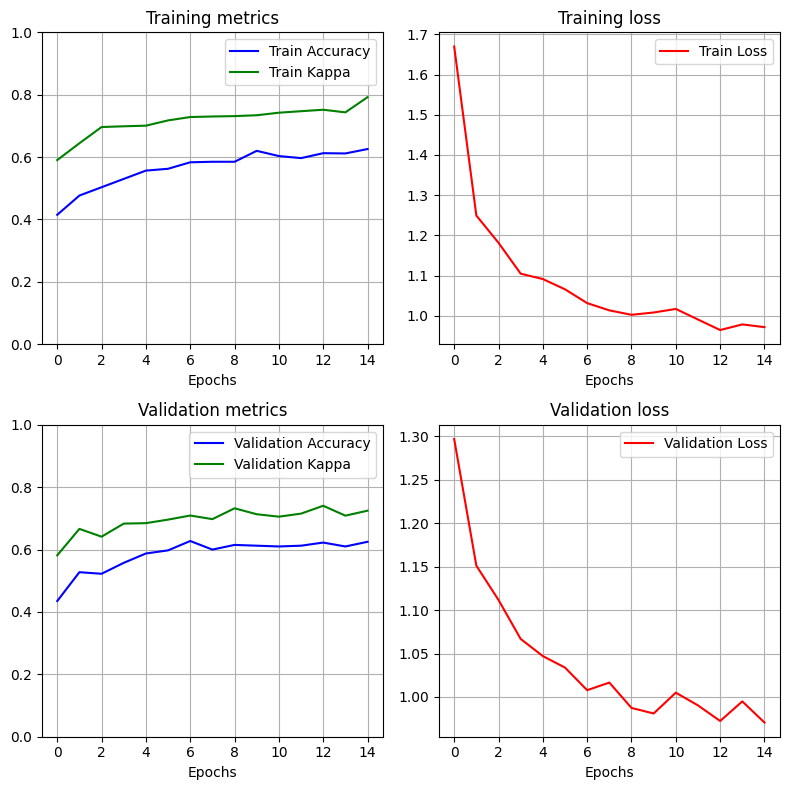

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    SLORandomPad((224, 224)),
    FundRandomRotate(prob=0.5, degree=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.3, 0.9)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    CutOut(24),
    #WhiteNoise()
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

num_epochs=15
name='finetuned_effnet.pth'
model=train_and_evaluate(model,transform_train,transform_test,name,f'./{name}/{name}')
#torch.save(model.state_dict(),f'./{name}/{name}')

### DENSENET

In [ ]:
def evaluate_model(model, test_loader, device, test_only=False, criterion=None, prediction_path='./test_predictions.csv'):
    model.eval()

    all_preds = []
    all_labels = []
    all_image_ids = []
    all_logits=[]

    with tqdm(total=len(test_loader), desc=f'Evaluating', unit=' batch', file=sys.stdout) as pbar:
        for i, data in enumerate(test_loader):

            if test_only:
                images = data
            else:
                images, labels = data

            if not isinstance(images, list):
                images = images.to(device)  # single image case
            else:
                images = [x.to(device) for x in images]  # dual images case

            with torch.no_grad():
                outputs = model(images)
                preds = torch.argmax(outputs, 1)

            if not isinstance(images, list):
                # single image case
                all_preds.extend(preds.cpu().numpy())
                all_logits.extend(outputs.cpu().numpy())
                # Update to use image_paths from the dataset
                image_ids = [
                    test_loader.dataset.image_paths[idx] for idx in
                    range(i * test_loader.batch_size, min((i + 1) * test_loader.batch_size, len(test_loader.dataset)))
                ]
                all_image_ids.extend(image_ids)
                if not test_only:
                    all_labels.extend(labels.numpy())
            else:
                # dual images case (You might need to adjust this part if you use dual images with APTOSDataset)
                for k in range(2):
                    all_preds.extend(preds.cpu().numpy())
                    # Update to use image_paths from the dataset
                    image_ids = [
                        test_loader.dataset.image_paths[idx] for idx in
                        range(i * test_loader.batch_size, min((i + 1) * test_loader.batch_size, len(test_loader.dataset)))
                    ]
                    all_image_ids.extend(image_ids)
                    if not test_only:
                        all_labels.extend(labels.numpy())

            pbar.update(1)

    # Save predictions to csv file for Kaggle online evaluation
    if test_only:
        df = pd.DataFrame({
            'ID': all_image_ids,
            'TARGET': all_preds
        })
        df.to_csv(prediction_path, index=False)
        print(f'[Test] Save predictions to {os.path.abspath(prediction_path)}')
    else:
        all_logits_tensor = torch.tensor(all_logits, dtype=torch.float32)  # Raw outputs
        all_labels_tensor = torch.tensor(all_labels, dtype=torch.long)  # True labels

        loss = criterion(all_logits_tensor, all_labels_tensor)
        metrics = compute_metrics(all_preds, all_labels)
        return metrics, loss

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet(num_classes=5).to(device)



print('Device:', device)
model = model.to(device)
#unfreeze backbone layers
for param in model.backbone.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


num_epochs = 5
_=train_model(
    model, train_loader, val_loader, device, criterion, optimizer, lr_scheduler, num_epochs
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 151MB/s]


Device: cuda

Epoch 1/5
Training: 100%|██████████| 92/92 [06:39<00:00,  4.34s/ batch, lr=1.0e-04, Loss=0.8049]
[Train] Kappa: 0.6088 Accuracy: 0.6758 Precision: 0.5833 Recall: 0.6758 Loss: 0.9197
[Train] Class 0: Precision: 0.8411, Recall: 0.9268
[Train] Class 1: Precision: 0.1795, Recall: 0.0700
[Train] Class 2: Precision: 0.5287, Recall: 0.7760
[Train] Class 3: Precision: 0.0000, Recall: 0.0000
[Train] Class 4: Precision: 0.0938, Recall: 0.0128
Evaluating: 100%|██████████| 12/12 [00:51<00:00,  4.32s/ batch]
[Val] Kappa: 0.7568 Accuracy: 0.8038 Precision: 0.7568 Recall: 0.7168

Epoch 2/5
Training: 100%|██████████| 92/92 [06:42<00:00,  4.37s/ batch, lr=1.0e-04, Loss=0.6856]
[Train] Kappa: 0.8092 Accuracy: 0.7614 Precision: 0.7196 Recall: 0.7614 Loss: 0.6536
[Train] Class 0: Precision: 0.9517, Recall: 0.9756
[Train] Class 1: Precision: 0.5215, Recall: 0.3233
[Train] Class 2: Precision: 0.5941, Recall: 0.8676
[Train] Class 3: Precision: 0.0769, Recall: 0.0065
[Train] Class 4: Precision: 

(DenseNet(
   (backbone): DenseNet(
     (features): Sequential(
       (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
       (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu0): ReLU(inplace=True)
       (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
       (denseblock1): _DenseBlock(
         (denselayer1): _DenseLayer(
           (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
           (relu1): ReLU(inplace=True)
           (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
           (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
           (relu2): ReLU(inplace=True)
           (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         )
         (denselayer2): _DenseLayer(
           (norm1): BatchNorm2d(96, eps

In [ ]:
def evaluate_model(model, test_loader, device,criterion=None, test_only=False, prediction_path='./test_predictions.csv'):
    model.eval()

    all_preds = []
    all_labels = []
    all_image_ids = []
    all_logits=[]

    with tqdm(total=len(test_loader), desc=f'Evaluating', unit=' batch', file=sys.stdout) as pbar:
        for i, data in enumerate(test_loader):

            if test_only:
                images = data
            else:
                images, labels = data

            if not isinstance(images, list):
                images = images.to(device)  # single image case
            else:
                images = [x.to(device) for x in images]  # dual images case

            with torch.no_grad():
                outputs = model(images)
                preds = torch.argmax(outputs, 1)

            if not isinstance(images, list):
                # single image case
                all_preds.extend(preds.cpu().numpy())
                all_logits.extend(outputs.cpu().numpy())
                image_ids = [
                    os.path.basename(test_loader.dataset.data[idx]['img_path']) for idx in
                    range(i * test_loader.batch_size, i * test_loader.batch_size + len(images))
                ]
                all_image_ids.extend(image_ids)
                if not test_only:
                    all_labels.extend(labels.numpy())
            else:
                # dual images case
                for k in range(2):
                    all_preds.extend(preds.cpu().numpy())
                    image_ids = [
                        os.path.basename(test_loader.dataset.data[idx][f'img_path{k + 1}']) for idx in
                        range(i * test_loader.batch_size, i * test_loader.batch_size + len(images[k]))
                    ]
                    all_image_ids.extend(image_ids)
                    if not test_only:
                        all_labels.extend(labels.numpy())

            pbar.update(1)

    # Save predictions to csv file for Kaggle online evaluation
    if test_only:
        df = pd.DataFrame({
            'ID': all_image_ids,
            'TARGET': all_preds
        })
        df.to_csv(prediction_path, index=False)
        print(f'[Test] Save predictions to {os.path.abspath(prediction_path)}')
    else:
        all_logits_tensor = torch.tensor(all_logits, dtype=torch.float32)  # Raw outputs
        all_labels_tensor = torch.tensor(all_labels, dtype=torch.long)  # True labels

        loss = criterion(all_logits_tensor, all_labels_tensor)
        metrics = compute_metrics(all_preds, all_labels)
        return metrics, loss

In [ ]:
model=DenseNet()
statedict=torch.load('aptos_densenet.pth')
model.load_state_dict(statedict)
#unfreeze backbone layers
for param in model.backbone.parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 49.5MB/s]
<ipython-input-17-88fd2129f917>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly

Device: cuda

Epoch 1/15
Training: 100%|██████████| 38/38 [00:14<00:00,  2.60 batch/s, lr=1.0e-04, Loss=1.4673]
[Train] Kappa: 0.5676 Accuracy: 0.4083 Precision: 0.4352 Recall: 0.4083 Loss: 1.6686
[Train] Class 0: Precision: 0.5133, Recall: 0.6417
[Train] Class 1: Precision: 0.3455, Recall: 0.3542
[Train] Class 2: Precision: 0.2620, Recall: 0.3625
[Train] Class 3: Precision: 0.6186, Recall: 0.2500
[Train] Class 4: Precision: 0.3600, Recall: 0.2250
Evaluating: 100%|██████████| 13/13 [00:03<00:00,  4.11 batch/s]
[Val] Kappa: 0.6531 Accuracy: 0.4825 Precision: 0.4390 Recall: 0.4825

Epoch 2/15
Training: 100%|██████████| 38/38 [00:11<00:00,  3.29 batch/s, lr=1.0e-04, Loss=1.1535]
[Train] Kappa: 0.6215 Accuracy: 0.4842 Precision: 0.4803 Recall: 0.4842 Loss: 1.2178
[Train] Class 0: Precision: 0.6060, Recall: 0.6750
[Train] Class 1: Precision: 0.4247, Recall: 0.3875
[Train] Class 2: Precision: 0.3110, Recall: 0.3667
[Train] Class 3: Precision: 0.5654, Recall: 0.5583
[Train] Class 4: Precision

<ipython-input-11-1213c203a0b5>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint, map_location='cpu')


Evaluating: 100%|██████████| 13/13 [00:03<00:00,  4.19 batch/s]
[Test] Save predictions to /content/finetuned_densenet.pth/test_predictions.csv


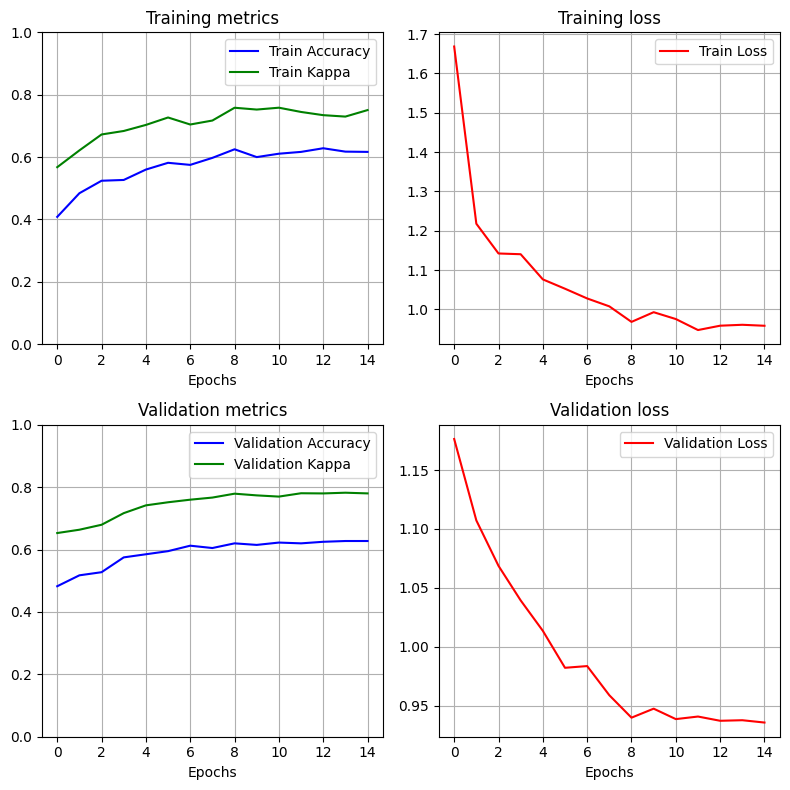

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    SLORandomPad((224, 224)),
    FundRandomRotate(prob=0.5, degree=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.3, 0.9)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    CutOut(24),
    #WhiteNoise()
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

num_epochs=15
name='finetuned_densenet.pth'
model=train_and_evaluate(model,transform_train,transform_test,name,f'./{name}/{name}')
#torch.save(model.state_dict(),f'./{name}/{name}')

### IMPLEMENT ATTENTION MECHANISMS

In [ ]:
import torch
from torch import nn
import numpy as np
from torchvision import models

In [ ]:
class ResNet18MHA(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Identity()  # Remove the original classification layer
        self.att = nn.MultiheadAttention(512, 8)
        self.norm = nn.LayerNorm(512)

        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x2,_=self.att(x,x,x)
        x=x+x2
        x=self.norm(x)
        x = self.fc(x)
        return x

In [ ]:
model= ResNet18MHA()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes=3, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // 16, 1, bias=False),
                               nn.ReLU(),
                               nn.Conv2d(in_planes // 16, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

In [ ]:
class ResNet18CSA(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Identity()
        self.backbone.avgpool=nn.Identity()
        self.ca = ChannelAttention(in_planes=512)
        self.sa = SpatialAttention()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x=x.reshape(x.size(0),512,7,7)
        x = self.ca(x) * x
        x = self.sa(x) * x
        x=self.avgpool(x)
        x=x[:,:,0,0]
        x = self.fc(x)
        return x

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Device: cuda

Epoch 1/15
Training: 100%|██████████| 38/38 [00:10<00:00,  3.64 batch/s, lr=1.0e-04, Loss=1.2358]
[Train] Kappa: 0.3734 Accuracy: 0.3925 Precision: 0.3607 Recall: 0.3925 Loss: 1.5053
[Train] Class 0: Precision: 0.5599, Recall: 0.8694
[Train] Class 1: Precision: 0.3077, Recall: 0.1000
[Train] Class 2: Precision: 0.2394, Recall: 0.4458
[Train] Class 3: Precision: 0.3729, Recall: 0.0917
[Train] Class 4: Precision: 0.0877, Recall: 0.0417
Evaluating: 100%|██████████| 13/13 [00:02<00:00,  5.76 batch/s]
[Val] Kappa: 0.5575 Accuracy: 0.4675 Precision: 0.5506 Recall: 0.4675

Epoch 2/15
Training: 100%|██████████| 38/38 [00:10<00:00,  3.60 batch/s, lr=1.0e-04, Loss=1.4441]
[Train] Kappa: 0.6438 Accuracy: 0.5208 Precision: 0.4646 Recall: 0.5208 Loss: 1.2019
[Train] Class 0: Precision: 0.7924, Recall: 0.9861
[Train] Class 1: Precision: 0.4296, Recall: 0.5083
[Train] Class 2: Precision: 0.2703, Recall: 0.2500
[Train] Class 3: Precision: 0.3755, Recall: 0.3583
[Train] Class 4: Precision

<ipython-input-11-1213c203a0b5>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint, map_location='cpu')



[Val] Kappa: 0.8268 Accuracy: 0.6675 Precision: 0.6543 Recall: 0.6675
[Val] Best kappa: 0.8304, Epoch 8
Evaluating: 100%|██████████| 13/13 [00:02<00:00,  5.44 batch/s]
[Test] Save predictions to /content/allaugs_csa.pth/test_predictions.csv


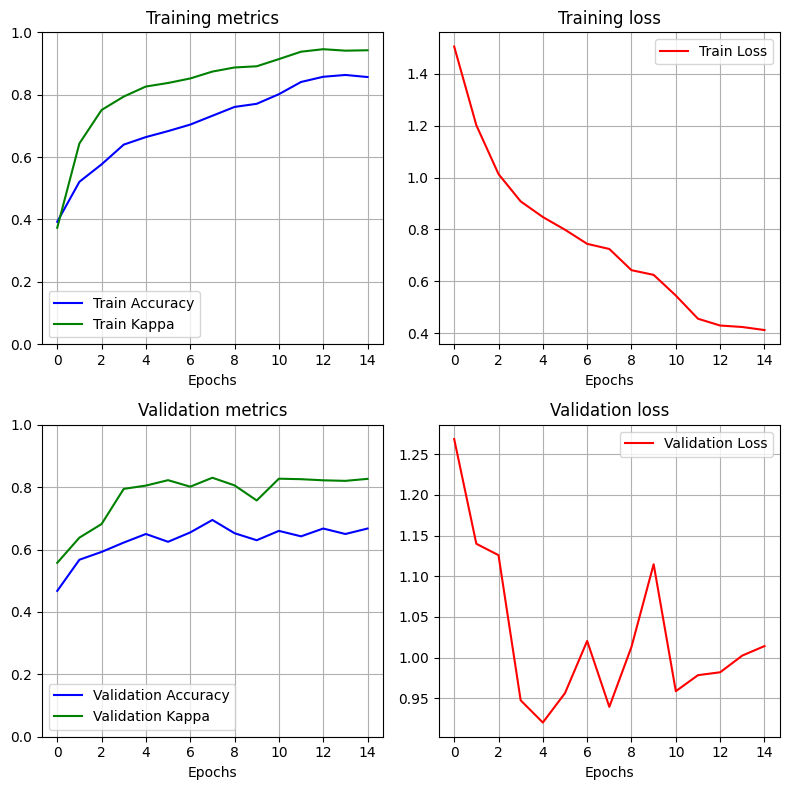

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    SLORandomPad((224, 224)),
    FundRandomRotate(prob=0.5, degree=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.3, 0.9)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    CutOut(24),
    #WhiteNoise()
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


name='allaugs_csa.pth'
model=ResNet18CSA()
model=train_and_evaluate(model,transform_train,transform_test,name,f'./{name}/{name}')
#torch.save(model.state_dict(),f'./{name}/{name}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Device: cuda

Epoch 1/15
Training: 100%|██████████| 38/38 [00:10<00:00,  3.48 batch/s, lr=1.0e-04, Loss=1.1883]
[Train] Kappa: 0.3721 Accuracy: 0.4042 Precision: 0.3485 Recall: 0.4042 Loss: 1.4346
[Train] Class 0: Precision: 0.4885, Recall: 0.8889
[Train] Class 1: Precision: 0.2718, Recall: 0.1167
[Train] Class 2: Precision: 0.2500, Recall: 0.1333
[Train] Class 3: Precision: 0.3772, Recall: 0.3583
[Train] Class 4: Precision: 0.2209, Recall: 0.1583
Evaluating: 100%|██████████| 13/13 [00:02<00:00,  5.90 batch/s]
[Val] Kappa: 0.6386 Accuracy: 0.5725 Precision: 0.4920 Recall: 0.5725

Epoch 2/15
Training: 100%|██████████| 38/38 [00:10<00:00,  3.49 batch/s, lr=1.0e-04, Loss=0.9613]
[Train] Kappa: 0.6740 Accuracy: 0.5308 Precision: 0.4929 Recall: 0.5308 Loss: 1.1837
[Train] Class 0: Precision: 0.7679, Recall: 0.9556
[Train] Class 1: Precision: 0.4246, Recall: 0.4458
[Train] Class 2: Precision: 0.3313, Recall: 0.2292
[Train] Class 3: Precision: 0.4176, Recall: 0.4750
[Train] Class 4: Precision

<ipython-input-11-1213c203a0b5>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint, map_location='cpu')



[Val] Kappa: 0.7577 Accuracy: 0.6450 Precision: 0.6222 Recall: 0.6450
[Val] Best kappa: 0.7936, Epoch 9
Evaluating: 100%|██████████| 13/13 [00:02<00:00,  5.07 batch/s]
[Test] Save predictions to /content/allaugs_mha.pth/test_predictions.csv


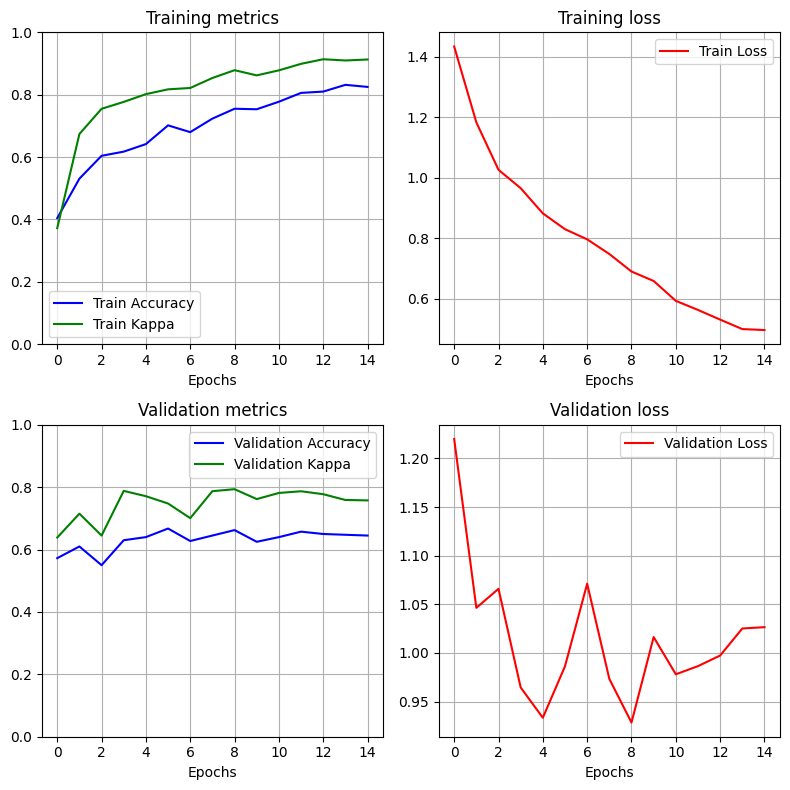

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    SLORandomPad((224, 224)),
    FundRandomRotate(prob=0.5, degree=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.3, 0.9)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    CutOut(24),
    #WhiteNoise()
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


name='allaugs_mha.pth'
model= ResNet18MHA()
model=train_and_evaluate(model,transform_train,transform_test,name,f'./{name}/{name}')
#torch.save(model.state_dict(),f'./{name}/{name}')

### ENSEMBLE TECHNIQUES

MAX VOTING

In [ ]:
def evaluate_model_maxvoting(model, test_loader, device,criterion=None, test_only=False, prediction_path='./test_predictions.csv'):
    model.eval()

    all_preds = []
    all_labels = []
    all_image_ids = []

    with tqdm(total=len(test_loader), desc=f'Evaluating', unit=' batch', file=sys.stdout) as pbar:
        for i, data in enumerate(test_loader):

            if test_only:
                images = data
            else:
                images, labels = data

            if not isinstance(images, list):
                images = images.to(device)  # single image case
            else:
                images = [x.to(device) for x in images]  # dual images case

            with torch.no_grad():
                preds = model(images)

            if not isinstance(images, list):
                # single image case
                all_preds.extend(preds.cpu().numpy())
                if not test_only:
                    all_labels.extend(labels.numpy())
            else:
                # dual images case
                for k in range(2):
                    all_preds.extend(preds.cpu().numpy())
                    image_ids = [
                        os.path.basename(test_loader.dataset.data[idx][f'img_path{k + 1}']) for idx in
                        range(i * test_loader.batch_size, i * test_loader.batch_size + len(images[k]))
                    ]
                    all_image_ids.extend(image_ids)
                    if not test_only:
                        all_labels.extend(labels.numpy())

            pbar.update(1)

    # Save predictions to csv file for Kaggle online evaluation
    if test_only:
        df = pd.DataFrame({
            'ID': all_image_ids,
            'TARGET': all_preds
        })
        df.to_csv(prediction_path, index=False)
        print(f'[Test] Save predictions to {os.path.abspath(prediction_path)}')
    else:
        all_labels_tensor = torch.tensor(all_labels, dtype=torch.long)  # True labels
        metrics = compute_metrics(all_preds, all_labels,per_class=True)
        return metrics

In [ ]:
train_dataset = RetinopathyDataset('/content/521153S-3005-final-project/DeepDRiD/train.csv', '/content/521153S-3005-final-project/DeepDRiD/train/', transform_train, mode)
val_dataset = RetinopathyDataset('/content/521153S-3005-final-project/DeepDRiD/val.csv', '/content/521153S-3005-final-project/DeepDRiD/val/', transform_test, mode)
test_dataset = RetinopathyDataset('/content/521153S-3005-final-project/DeepDRiD/test.csv', '/content/521153S-3005-final-project/DeepDRiD/test/', transform_test, mode, test=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()


In [ ]:
class MaxVotingEnsemble(nn.Module):
    def __init__(self, model1,model2,model3):
        super().__init__()
        self.model1=model1
        self.model2=model2
        self.model3=model3
        for param in self.model1.parameters():
          param.requires_grad = False
        for param in self.model2.parameters():
          param.requires_grad = False
        for param in self.model3.parameters():
          param.requires_grad = False

    def forward(self, x):
        pred1 = self.model1(x)
        pred2 = self.model2(x)
        pred3 = self.model3(x)
        class1 = torch.argmax(pred1, dim=1)
        class2 = torch.argmax(pred2, dim=1)
        class3 = torch.argmax(pred3, dim=1)

        stacked_classes = torch.stack([class1, class2, class3], dim=0)
        most_voted_class, _ = torch.mode(stacked_classes, dim=0)
        return most_voted_class

'\n    def forward(self, x):\n        pred1 = self.model1(x)\n        pred2 = self.model2(x)\n        pred3 = self.model3(x)\n        class1 = torch.argmax(pred1, dim=1)\n        class2 = torch.argmax(pred2, dim=1)\n        class3 = torch.argmax(pred3, dim=1)\n        \n        stacked_classes = torch.stack([class1, class2, class3], dim=0)\n        most_voted_class, _ = torch.mode(stacked_classes, dim=0)\n        return most_voted_class\n        '

In [ ]:
model1=DenseNet()
statedict=torch.load('aptos_densenet.pth',map_location=torch.device('cpu'))
model1.load_state_dict(statedict)
model2=ResNet18()
statedict=torch.load('aptos_resnet.pth',map_location=torch.device('cpu'))
model2.load_state_dict(statedict)
model3=EffNet()
statedict=torch.load('aptos_effnet.pth',map_location=torch.device('cpu'))
model3.load_state_dict(statedict)
model=MaxVotingEnsemble(model1,model2,model3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-37-7a5e886f5594>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more 

In [ ]:
val_metrics = evaluate_model_maxvoting(model, val_loader, device, criterion=criterion)
val_accuracy, val_precision, val_recall, val_kappa = val_metrics[:4]
print(f'Kappa: {val_kappa:.4f} Accuracy: {val_accuracy:.4f} '
      f'Precision: {val_precision:.4f} Recall: {val_recall:.4f}')

Kappa: 0.8241 Accuracy: 0.6675 Precision: 0.6513 Recall: 0.6675


LOGISTIC REGRESSION

In [ ]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, model1, model2, model3):
        super(LogisticRegression, self).__init__()
        self.model1=model1
        self.model2=model2
        self.model3=model3
        self.linear = torch.nn.Linear(15, 5)

        #freeze models
        for param in self.model1.parameters():
            param.requires_grad = False

        for param in self.model2.parameters():
            param.requires_grad = False

        for param in self.model3.parameters():
            param.requires_grad = False

    def forward(self, x):
        o1=self.model1(x)
        o2=self.model2(x)
        o3=self.model3(x)
        o = torch.cat([o1, o2, o3], dim=1)
        y_pred = self.linear(o)
        y_pred = torch.nn.functional.softmax(y_pred, dim=1)
        return y_pred

In [ ]:
model1=DenseNet()
statedict=torch.load('aptos_densenet.pth')
model1.load_state_dict(statedict)
model2=ResNet18()
statedict=torch.load('aptos_resnet.pth')
model2.load_state_dict(statedict)
model3=EffNet()
statedict=torch.load('aptos_effnet.pth')
model3.load_state_dict(statedict)
model=LogisticRegression(model1,model2,model3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-28-d85664095c06>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more 

Device: cuda

Epoch 1/10
Training: 100%|██████████| 38/38 [00:14<00:00,  2.65 batch/s, lr=1.0e-02, Loss=1.3956]
[Train] Kappa: 0.3360 Accuracy: 0.2800 Precision: 0.2670 Recall: 0.2800 Loss: 1.5805
[Train] Class 0: Precision: 0.2000, Recall: 0.0722
[Train] Class 1: Precision: 0.2722, Recall: 0.6000
[Train] Class 2: Precision: 0.2574, Recall: 0.2167
[Train] Class 3: Precision: 0.4089, Recall: 0.3833
[Train] Class 4: Precision: 0.1930, Recall: 0.1833
Evaluating: 100%|██████████| 13/13 [00:03<00:00,  3.37 batch/s]
[Val] Kappa: 0.6263 Accuracy: 0.4875 Precision: 0.4240 Recall: 0.4875

Epoch 2/10
Training: 100%|██████████| 38/38 [00:12<00:00,  2.95 batch/s, lr=1.0e-02, Loss=1.4442]
[Train] Kappa: 0.6410 Accuracy: 0.5017 Precision: 0.4383 Recall: 0.5017 Loss: 1.3998
[Train] Class 0: Precision: 0.5238, Recall: 0.8556
[Train] Class 1: Precision: 0.4737, Recall: 0.0375
[Train] Class 2: Precision: 0.4062, Recall: 0.3792
[Train] Class 3: Precision: 0.5257, Recall: 0.8083
[Train] Class 4: Precision

<ipython-input-11-1213c203a0b5>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint, map_location='cpu')


Evaluating: 100%|██████████| 13/13 [00:03<00:00,  3.44 batch/s]
[Test] Save predictions to /content/logreg.pth/test_predictions.csv


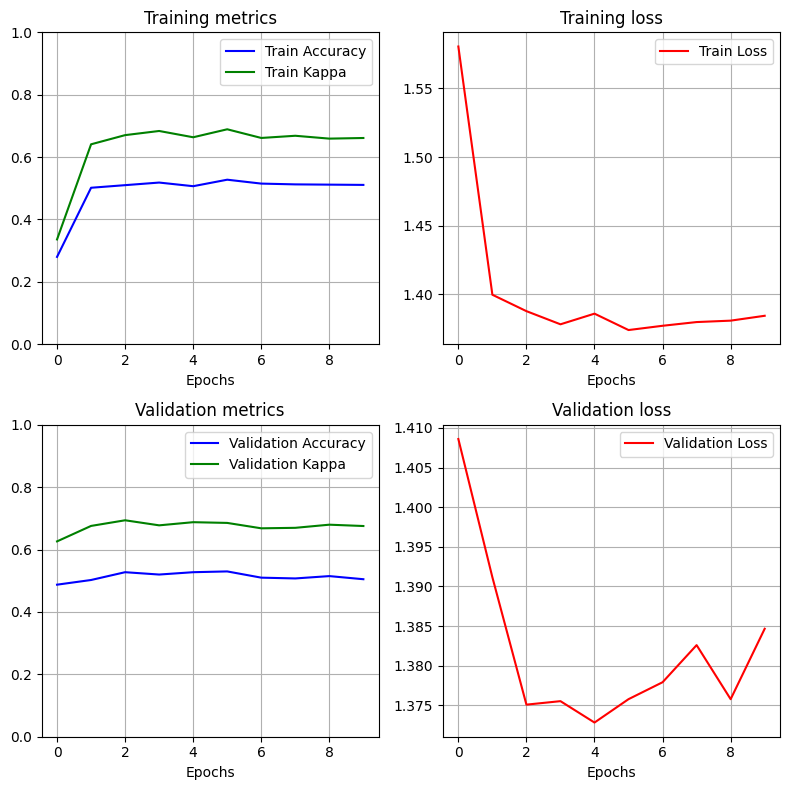

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

num_epochs=10
learning_rate = 0.01
name='logreg.pth'
model=LogisticRegression(model1,model2,model3)
model=train_and_evaluate(model,transform_train,transform_test,name,f'./{name}/{name}')
#torch.save(model.state_dict(),f'./{name}/{name}')

BAGGING

In [ ]:
class BaggingEnsemble(nn.Module):
    def __init__(self, modellist):
        super().__init__()
        self.model1=modellist[0]
        self.model2=modellist[1]
        self.model3=modellist[2]
        self.model4=modellist[3]

    def forward(self, x):
        pred1=self.model1(x).values()
        pred2=self.model2(x).values()
        pred3=self.model3(x).values()
        pred4=self.model4(x).values()
        pred=(pred1+pred2+pred3)/4
        return pred

In [ ]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes=3, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // 16, 1, bias=False),
                               nn.ReLU(),
                               nn.Conv2d(in_planes // 16, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class ResNet18CSA(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.5):
        super().__init__()

        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Identity()
        self.backbone.avgpool=nn.Identity()
        self.ca = ChannelAttention(in_planes=512)
        self.sa = SpatialAttention()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x=x.reshape(x.size(0),512,7,7)
        x = self.ca(x) * x
        x = self.sa(x) * x
        x=self.avgpool(x)
        x=x[:,:,0,0]
        x = self.fc(x)
        return x

In [ ]:
def evaluate_model(model, validset, device,criterion=None, test_only=False, prediction_path='./test_predictions.csv'):
    model.eval()
    criterion = nn.CrossEntropyLoss()

    all_preds = []
    all_labels = []
    all_image_ids = []
    all_logits=[]

    with tqdm(total=int(len(validset)/32), desc=f'Training', unit=' batch', file=sys.stdout) as pbar:
          for index in range(0, len(validset), 32):

            if test_only:
                images = validset[index]
            else:
                images, labels = validset[index]

            if not isinstance(images, list):
                images = images.to(device)  # single image case
            else:
                images = [x.to(device) for x in images]  # dual images case

            with torch.no_grad():
                outputs = model(images)
                preds = torch.argmax(outputs, 1)

            if not isinstance(images, list):
                # single image case
                all_preds.extend(preds.cpu().numpy())
                all_logits.extend(outputs.cpu().numpy())

                if not test_only:
                    all_labels.extend(labels.numpy())
            else:
                # dual images case
                for k in range(2):
                    all_preds.extend(preds.cpu().numpy())
                    image_ids = [
                        os.path.basename(test_loader.dataset.data[idx][f'img_path{k + 1}']) for idx in
                        range(i * test_loader.batch_size, i * test_loader.batch_size + len(images[k]))
                    ]
                    all_image_ids.extend(image_ids)
                    if not test_only:
                        all_labels.extend(labels.numpy())

            pbar.update(1)

    # Save predictions to csv file for Kaggle online evaluation
    if test_only:
        df = pd.DataFrame({
            'ID': all_image_ids,
            'TARGET': all_preds
        })
        df.to_csv(prediction_path, index=False)
        print(f'[Test] Save predictions to {os.path.abspath(prediction_path)}')
    else:
        all_logits_tensor = torch.tensor(all_logits, dtype=torch.float32)  # Raw outputs
        all_labels_tensor = torch.tensor(all_labels, dtype=torch.long)  # True labels

        loss = criterion(all_logits_tensor, all_labels_tensor)
        metrics = compute_metrics(all_preds, all_labels)
        return metrics, loss

In [ ]:
def train_and_evaluate_bagging(modellist,datasets,transform_train,transform_valid,name,checkpoint):
  try:
    os.mkdir('./'+name)
  except:
    pass

  best_model = BaggingEnsemble(modellist).state_dict()
  best_epoch = None
  best_val_kappa = -1.0  # Initialize the best kappa score

  train_accs=[]
  train_ks=[]
  valid_accs=[]
  valid_ks=[]


  # Define the weighted CrossEntropyLoss
  criterion = nn.CrossEntropyLoss()

  optimizers = [torch.optim.Adam(params=model.parameters(), lr=learning_rate) for model in modellist]
  lr_schedulers = [torch.optim.lr_scheduler.StepLR(optimizers[i], step_size=10, gamma=0.1) for i in range(len(modellist))]

  # Use GPU device is possible
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print('Device:', device)

  for epoch in range(1, num_epochs + 1):
    print(f'\nEpoch {epoch}/{num_epochs}')
    running_loss = []
    all_preds = []
    all_labels = []

    kappas=[0 for model in modellist]
    accuracies=[0 for model in modellist]
    losses=[0 for model in modellist]

    for i in range(len(modellist)):
      model=modellist[i]
      trainset,validset=datasets[i]
      optimizer=optimizers[i]
      lr_scheduler=lr_schedulers[i]

      model = model.to(device)

      #train mode
      model.train()

      with tqdm(total=int(len(trainset)/32), desc=f'Training', unit=' batch', file=sys.stdout) as pbar:
          for index in range(0, len(trainset), 32):
            images,labels=trainset[index]
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels.long())

            loss.backward()
            optimizer.step()

            preds = torch.argmax(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            running_loss.append(loss.item())

            pbar.set_postfix({'lr': f'{optimizer.param_groups[0]["lr"]:.1e}', 'Loss': f'{loss.item():.4f}'})
            pbar.update(1)

      lr_scheduler.step()


      train_metrics = compute_metrics(all_preds, all_labels, per_class=True)
      kappa, accuracy, precision, recall = train_metrics[:4]
      kappas.append(kappa)
      accuracies.append(accuracy)
      losses.append(sum(running_loss) / len(running_loss))

    #logging
    accuracy=sum(accuracies)/len(accuracies)
    kappa=sum(kappas)/len(kappas)
    train_accs.append(accuracy)
    train_ks.append(kappa)

    print(f'[Train] Kappa: {kappa:.4f} Accuracy: {accuracy:.4f} '
          f'Precision: {precision:.4f} Recall: {recall:.4f} Loss: {sum(running_loss) / len(running_loss):.4f}')

    # Evaluation on the validation set at the end of each epoch
    val_metrics,val_loss = evaluate_model(model, validset, device)
    val_kappa, val_accuracy, val_precision, val_recall = val_metrics[:4]
    print(f'[Val] Kappa: {val_kappa:.4f} Accuracy: {val_accuracy:.4f} '
          f'Precision: {val_precision:.4f} Recall: {val_recall:.4f}')

    #logging
    valid_accs.append(val_accuracy)
    valid_ks.append(val_kappa)

    if val_kappa > best_val_kappa:
        best_val_kappa = val_kappa
        best_epoch = epoch
        best_model = model.state_dict()
        torch.save(best_model, checkpoint)



  # Make predictions on testing set and save the prediction results
  #evaluate_model(model, test_loader, device, test_only=True,prediction_path='./'+name+'/test_predictions.csv')


  fig, axes = plt.subplots(2, 1, figsize=(8, 8))

  # Plot training loss
  axes[0].plot(np.array(train_accs), label="Train Accuracy", color="blue")
  axes[0].plot(np.array(train_ks), label="Train Kappa", color="green")
  axes[0].set_title("Training")
  axes[0].set_xlabel("Epochs")
  axes[0].legend()
  axes[0].grid(True)
  axes[0].set_ylim(0, 1)

  # Plot validation loss
  axes[1].plot(np.array(valid_accs), label="Validation Accuracy", color="blue")
  axes[1].plot(np.array(valid_ks), label="Validation Kappa", color="green")
  axes[1].set_title("Validation")
  axes[1].set_xlabel("Epochs")
  axes[1].set_ylabel("Loss")
  axes[1].legend()
  axes[1].grid(True)
  axes[1].set_ylim(0, 1)

  # Adjust layout
  plt.tight_layout()
  plt.show()
  return model

In [ ]:
import numpy as np

class Processed_dataset(Dataset):
    def __init__(self, imgs,labels,batchs=8):
        self.imgs=torch.cat(imgs)
        self.labels=torch.cat(labels)
        self.batch_size=batchs

    def __len__(self):
        return self.labels.size(0)

    def __getitem__(self, index, bsize=32):
          return self.get_item(index,bsize)

    def get_item(self, index, bsize):
        if index+bsize>=len(self.labels):
          return self.imgs[index:],self.labels[index:]
        return self.imgs[index:index+bsize], self.labels[index:index+bsize]

In [ ]:
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

imgs=[]
lbls=[]

d1 = RetinopathyDataset('/content/521153S-3005-final-project/DeepDRiD/train.csv', '/content/521153S-3005-final-project/DeepDRiD/train/', transform_test, 'single')
d2 = RetinopathyDataset('/content/521153S-3005-final-project/DeepDRiD/val.csv', '/content/521153S-3005-final-project/DeepDRiD/val/', transform_test, 'single')

for i in range(len(d1)):
  data=d1[i]
  imgs.append(data[0])
  lbls.append(data[1])

for i in range(len(d2)):
  data=d2[i]
  imgs.append(data[0])
  lbls.append(data[1])

imgs=np.array(imgs)
imgs=torch.tensor(imgs)
lbls=torch.tensor(lbls)

imgs.shape, lbls.shape

(torch.Size([1600, 3, 224, 224]), torch.Size([1600]))

In [ ]:
torch.manual_seed(11)

perm=torch.randperm(imgs.size(0))
shuffled_imgs = imgs[perm]
shuffled_lbls = lbls[perm]

In [ ]:
train1=Processed_dataset([imgs[:1200]],[lbls[:1200]])
valid1=Processed_dataset([imgs[1200:]],[lbls[1200:]])

train2=Processed_dataset([imgs[:800],imgs[1200:]],[lbls[:800],lbls[1200:]])
valid2=Processed_dataset([imgs[800:1200]],[lbls[800:1200]])

train3=Processed_dataset([imgs[:400],imgs[800:]],[lbls[:400],lbls[800:]])
valid3=Processed_dataset([imgs[400:800]],[lbls[400:800]])

train4=Processed_dataset([imgs[400:]],[lbls[400:]])
valid4=Processed_dataset([imgs[:400]],[lbls[:400]])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Device: cuda

Epoch 1/15
Training: 38 batch [00:03,  9.83 batch/s, lr=1.0e-03, Loss=2.0933]                    
Training: 38 batch [00:03,  9.95 batch/s, lr=1.0e-03, Loss=1.8080]                    
Training: 38 batch [00:03,  9.74 batch/s, lr=1.0e-03, Loss=1.6177]                    
Training: 38 batch [00:03,  9.78 batch/s, lr=1.0e-03, Loss=1.6458]                    
[Train] Kappa: 0.2184 Accuracy: 0.1895 Precision: 0.3184 Recall: 0.3762 Loss: 1.4937
Training: 13 batch [00:00, 33.48 batch/s]                    
[Val] Kappa: 0.5103 Accuracy: 0.4025 Precision: 0.2209 Recall: 0.4025

Epoch 2/15
Training: 38 batch [00:03,  9.78 batch/s, lr=1.0e-03, Loss=2.3146]                    
Training: 38 batch [00:03,  9.76 batch/s, lr=1.0e-03, Loss=1.8678]                    
Training: 38 batch [00:03,  9.95 batch/s, lr=1.0e-03, Loss=1.5215]                    
Training: 38 batch [00:03, 10.02 batch/s, lr=1.0e-03, Loss=1.6042]                    
[Train] Kappa: 0.2530 Accuracy: 0.2190 Precision: 

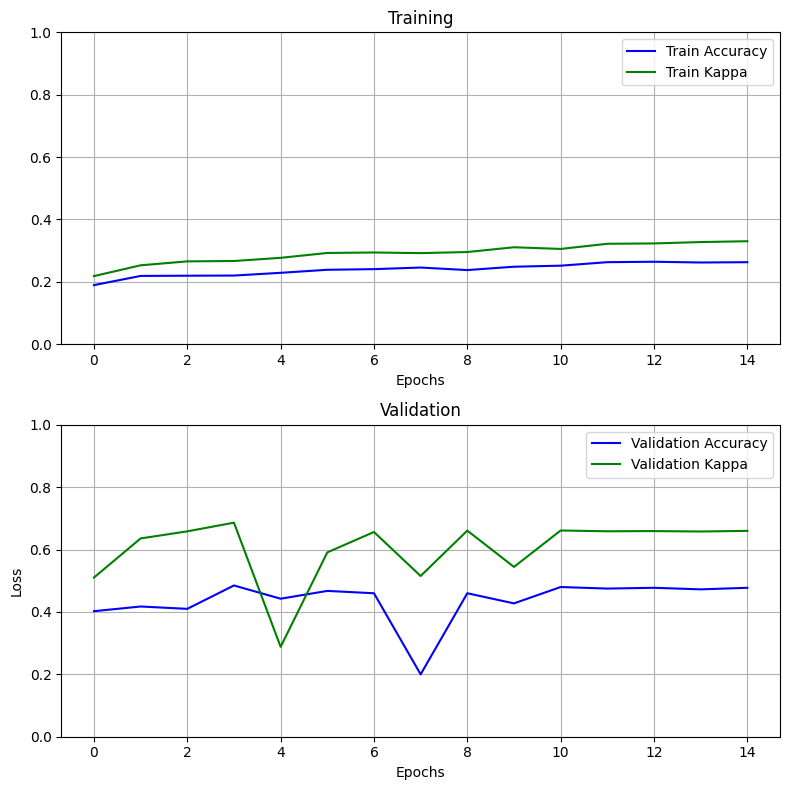

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    SLORandomPad((224, 224)),
    FundRandomRotate(prob=0.5, degree=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.3, 0.9)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    CutOut(24),
    #WhiteNoise()
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

num_epochs=15
learning_rate=0.001
modellist=[ResNet18CSA() for _ in range(4)]
#modellist=[dummy() for _ in range(4)]
datasets=[[train1,valid1],[train2,valid2],[train3,valid3],[train4,valid4]]
name='csa_bagging'
model=train_and_evaluate_bagging(modellist, datasets,transform_train, transform_test,name,f'./{name}/{name}')

In [ ]:
lbls=np.array(lbls)
for i in range(5):
  print(f'Class {i}: {len(lbls[lbls==i])}')

Class 0: 480
Class 1: 320
Class 2: 320
Class 3: 320
Class 4: 160


### BEN GRAHAM'S PREPROCESSING

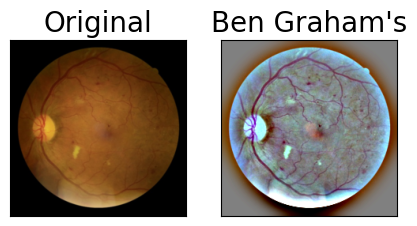

In [ ]:
import cv2

class ben_preprocess:
    def __init__(self,mean=0.0,std=0.1):
        self.mean=mean
        self.std=std
    def __call__(self, image,sigmaX=10):
      image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)
      image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), sigmaX), -4, 128)
      return Image.fromarray(image)


# visualize
fig,axs=plt.subplots(1,2,figsize=(5,8))
axs=axs.flatten()
sample_path = 'prova.jpg'
orimg=plt.imread(sample_path)
orimg=transforms.Resize((224,224))(Image.fromarray(orimg))
orimg=np.array(orimg)
ben=ben_preprocess()

#original
axs[0].imshow(orimg)
axs[0].set_title("Original", fontsize=20)

img=ben(orimg)
axs[1].imshow(img)
axs[1].set_title("Ben Graham's", fontsize=20)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0.5)
plt.show()

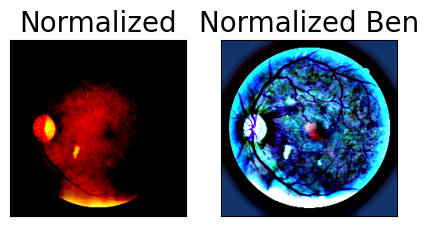

In [ ]:
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    ben_preprocess(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# visualize
fig,axs=plt.subplots(1,2,figsize=(5,8))
axs=axs.flatten()
sample_path = 'prova.jpg'
orimg=Image.open(sample_path)
#original
imgfirst=transform_train(orimg)
imgfirst=np.array(imgfirst)
imgfirst = np.transpose(imgfirst, (1, 2, 0))
axs[0].imshow(imgfirst)
axs[0].set_title("Normalized", fontsize=20)

img=transform_test(orimg)
img=np.array(img)
img = np.transpose(img, (1, 2, 0))
axs[1].imshow(img)
axs[1].set_title("Normalized Ben", fontsize=20)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0.5)
plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Device: cuda

Epoch 1/15
Training: 100%|██████████| 38/38 [00:31<00:00,  1.21 batch/s, lr=1.0e-04, Loss=1.2526]
[Train] Kappa: 0.2393 Accuracy: 0.3467 Precision: 0.3123 Recall: 0.3467 Loss: 1.4764
[Train] Class 0: Precision: 0.4462, Recall: 0.6444
[Train] Class 1: Precision: 0.3023, Recall: 0.2167
[Train] Class 2: Precision: 0.2521, Recall: 0.2542
[Train] Class 3: Precision: 0.2894, Recall: 0.2833
[Train] Class 4: Precision: 0.0968, Recall: 0.0250
Evaluating: 100%|██████████| 13/13 [00:07<00:00,  1.68 batch/s]
[Val] Kappa: 0.6929 Accuracy: 0.5650 Precision: 0.4910 Recall: 0.5650

Epoch 2/15
Training: 100%|██████████| 38/38 [00:31<00:00,  1.21 batch/s, lr=1.0e-04, Loss=0.9787]
[Train] Kappa: 0.6836 Accuracy: 0.5208 Precision: 0.4902 Recall: 0.5208 Loss: 1.1585
[Train] Class 0: Precision: 0.6998, Recall: 0.9000
[Train] Class 1: Precision: 0.4395, Recall: 0.2875
[Train] Class 2: Precision: 0.3155, Recall: 0.2458
[Train] Class 3: Precision: 0.4426, Recall: 0.6750
[Train] Class 4: Precision

<ipython-input-11-1213c203a0b5>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint, map_location='cpu')



[Val] Kappa: 0.8176 Accuracy: 0.6550 Precision: 0.6427 Recall: 0.6550
[Val] Best kappa: 0.8216, Epoch 6
Evaluating: 100%|██████████| 13/13 [00:07<00:00,  1.81 batch/s]
[Test] Save predictions to /content/densenet_benpp.pth/test_predictions.csv


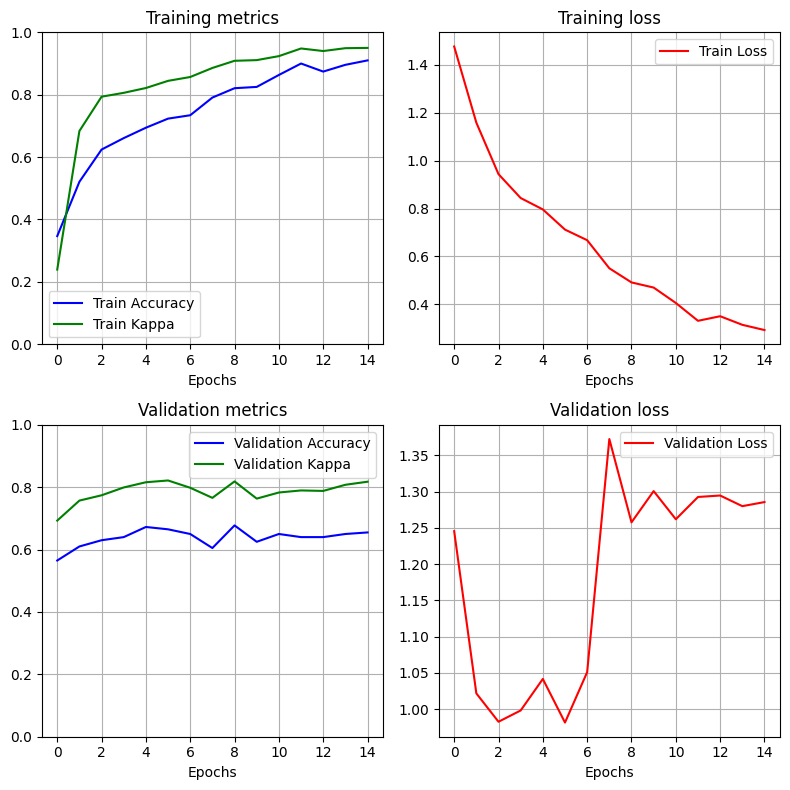

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    ben_preprocess(),
    SLORandomPad((224, 224)),
    FundRandomRotate(prob=0.5, degree=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.3, 0.9)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    CutOut(24),
    #WhiteNoise()
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    ben_preprocess(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

num_epochs=15
learning_rate=0.0001
name='densenet_benpp.pth'
model=DenseNet()
model=train_and_evaluate(model,transform_train,transform_test,name,f'./{name}/{name}')
#torch.save(model.state_dict(),f'./{name}/{name}')

### CIRCULAR CROPPING

(224, 224)
200704


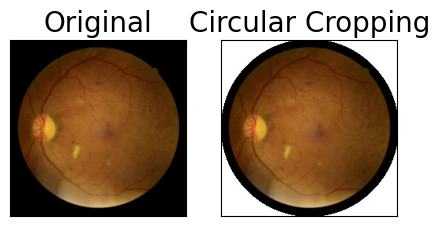

In [ ]:
import PIL

class circcrop:
    def __init__(self):
        pass
    def __call__(self, img):
      img=Image.fromarray(np.array(img))
      print(img.size)
      height,width = img.size
      lum_img = Image.new('L', [height,width] , 0)

      draw = PIL.ImageDraw.Draw(lum_img)
      draw.pieslice([(0,0), (height,width)], 0, 360,
                    fill = 255, outline = "white")
      img_arr =np.array(img)
      lum_img_arr =np.array(lum_img)
      final_img_arr = np.dstack((img_arr,lum_img_arr))
      return final_img_arr

# visualize
fig,axs=plt.subplots(1,2,figsize=(5,8))
axs=axs.flatten()
sample_path = 'prova.jpg'
orimg=plt.imread(sample_path)
orimg=transforms.Resize((224,224))(Image.fromarray(orimg))
circ_crop=circcrop()
#original
axs[0].imshow(orimg)
axs[0].set_title("Original", fontsize=20)

img=circ_crop(orimg)
print(img.size)
axs[1].imshow(img)
axs[1].set_title("Circular Cropping", fontsize=20)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0.5)
plt.show()

### HISTOGRAM EQUALIZING

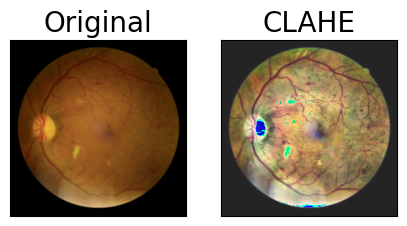

In [ ]:
class clahe:
    def __init__(self):
        pass
    def __call__(self, img):
      #img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
      # The declaration of CLAHE
      # clipLimit -> Threshold for contrast limiting
      b, g, r = cv2.split(np.array(img))

      # Create CLAHE object for contrast enhancement
      clahe = cv2.createCLAHE(clipLimit=5)

      # Apply CLAHE to each channel
      r = clahe.apply(r)
      g = clahe.apply(g)
      b = clahe.apply(b)

      # Merge the channels back into a single image
      final_img = cv2.merge([b, g, r])

      # Optionally, add 30 to each pixel value (ensure valid range 0-255)
      final_img = np.clip(final_img + 30, 0, 255).astype(np.uint8)
      final_img=Image.fromarray(final_img)

      return final_img

# visualize
fig,axs=plt.subplots(1,2,figsize=(5,8))
axs=axs.flatten()
sample_path = 'prova.jpg'
orimg=plt.imread(sample_path)
orimg=transforms.Resize((224,224))(Image.fromarray(orimg))
orimg=np.array(orimg)
histeq=clahe()
#original
axs[0].imshow(orimg)
axs[0].set_title("Original", fontsize=20)

img=histeq(orimg)
axs[1].imshow(img)
axs[1].set_title("CLAHE", fontsize=20)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0.5)
plt.show()

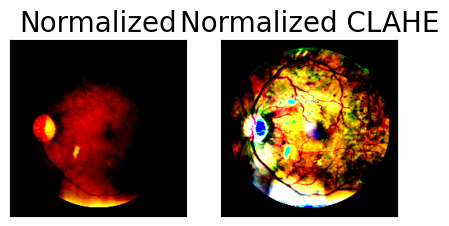

In [ ]:
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    clahe(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# visualize
fig,axs=plt.subplots(1,2,figsize=(5,8))
axs=axs.flatten()
sample_path = 'prova.jpg'
orimg=Image.open(sample_path)
#original
imgfirst=transform_train(orimg)
imgfirst=np.array(imgfirst)
imgfirst = np.transpose(imgfirst, (1, 2, 0))
axs[0].imshow(imgfirst)
axs[0].set_title("Normalized", fontsize=20)

img=transform_test(orimg)
img=np.array(img)
img = np.transpose(img, (1, 2, 0))
axs[1].imshow(img)
axs[1].set_title("Normalized CLAHE", fontsize=20)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0.5)
plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Device: cuda

Epoch 1/15
Training: 100%|██████████| 38/38 [00:21<00:00,  1.74 batch/s, lr=1.0e-04, Loss=0.9549]
[Train] Kappa: 0.3138 Accuracy: 0.4075 Precision: 0.3710 Recall: 0.4075 Loss: 1.4230
[Train] Class 0: Precision: 0.4923, Recall: 0.7944
[Train] Class 1: Precision: 0.3373, Recall: 0.4708
[Train] Class 2: Precision: 0.4000, Recall: 0.0250
[Train] Class 3: Precision: 0.3293, Recall: 0.3417
[Train] Class 4: Precision: 0.1000, Recall: 0.0167
Evaluating: 100%|██████████| 13/13 [00:03<00:00,  3.50 batch/s]
[Val] Kappa: 0.5478 Accuracy: 0.5075 Precision: 0.5582 Recall: 0.5075

Epoch 2/15
Training: 100%|██████████| 38/38 [00:22<00:00,  1.72 batch/s, lr=1.0e-04, Loss=0.7848]
[Train] Kappa: 0.6921 Accuracy: 0.5408 Precision: 0.5020 Recall: 0.5408 Loss: 1.1284
[Train] Class 0: Precision: 0.7500, Recall: 0.8917
[Train] Class 1: Precision: 0.4365, Recall: 0.5583
[Train] Class 2: Precision: 0.4034, Recall: 0.2000
[Train] Class 3: Precision: 0.4416, Recall: 0.5833
[Train] Class 4: Precision

<ipython-input-11-1213c203a0b5>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint, map_location='cpu')


Evaluating: 100%|██████████| 13/13 [00:03<00:00,  3.53 batch/s]
[Test] Save predictions to /content/densenet_clahe.pth/test_predictions.csv


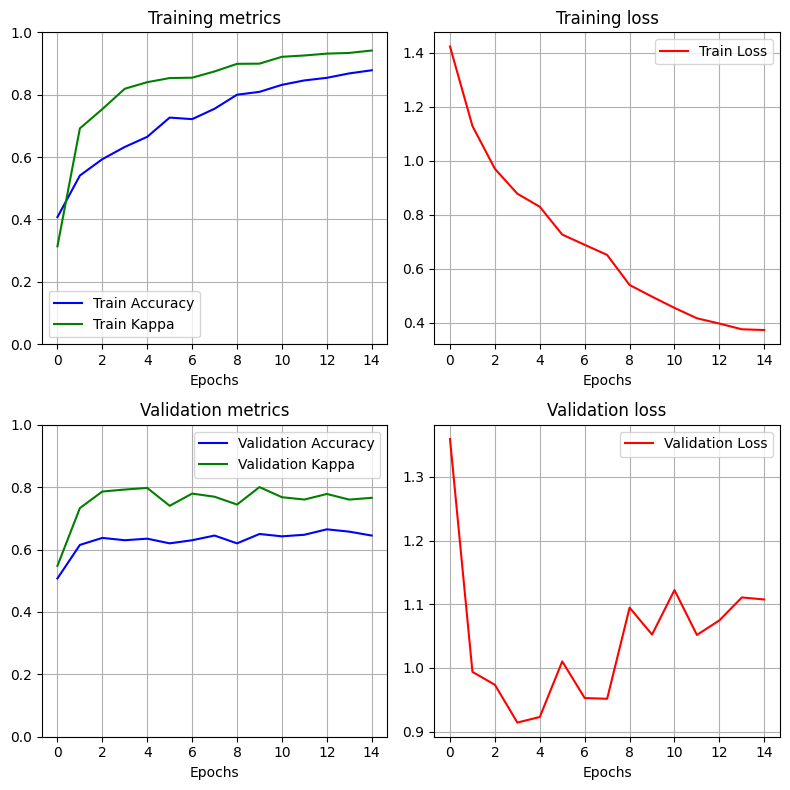

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    clahe(),
    SLORandomPad((224, 224)),
    FundRandomRotate(prob=0.5, degree=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.3, 0.9)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    CutOut(24),
    #WhiteNoise()
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    clahe(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

num_epochs=15
name='densenet_clahe.pth'
model=DenseNet()
model=train_and_evaluate(model,transform_train,transform_test,name,f'./{name}/{name}')
#torch.save(model.state_dict(),f'./{name}/{name}')

GAUSSIAN BLUR

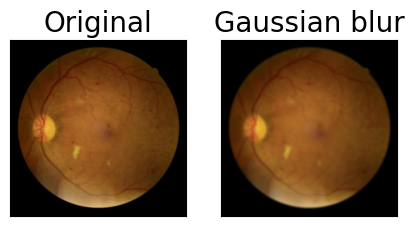

In [ ]:
class gaussian_blur:
    def __init__(self):
        pass
    def __call__(self, img):
      blur = cv2.GaussianBlur(np.array(img),(5,5),0)
      blur=Image.fromarray(blur)
      return blur

# visualize
fig,axs=plt.subplots(1,2,figsize=(5,8))
axs=axs.flatten()
sample_path = 'prova.jpg'
orimg=plt.imread(sample_path)
orimg=transforms.Resize((224,224))(Image.fromarray(orimg))
orimg=np.array(orimg)
noise=gaussian_blur()
#original
axs[0].imshow(orimg)
axs[0].set_title("Original", fontsize=20)

img=noise(orimg)
axs[1].imshow(img)
axs[1].set_title("Gaussian blur", fontsize=20)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0.5)
plt.show()

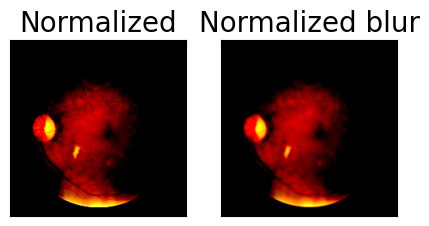

In [ ]:
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    gaussian_blur(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# visualize
fig,axs=plt.subplots(1,2,figsize=(5,8))
axs=axs.flatten()
sample_path = 'prova.jpg'
orimg=Image.open(sample_path)
#original
imgfirst=transform_train(orimg)
imgfirst=np.array(imgfirst)
imgfirst = np.transpose(imgfirst, (1, 2, 0))
axs[0].imshow(imgfirst)
axs[0].set_title("Normalized", fontsize=20)

img=transform_test(orimg)
img=np.array(img)
img = np.transpose(img, (1, 2, 0))
axs[1].imshow(img)
axs[1].set_title("Normalized blur", fontsize=20)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0.5)
plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Device: cuda

Epoch 1/15
Training: 100%|██████████| 38/38 [00:20<00:00,  1.89 batch/s, lr=1.0e-04, Loss=1.0265]
[Train] Kappa: 0.2329 Accuracy: 0.3883 Precision: 0.3363 Recall: 0.3883 Loss: 1.4188
[Train] Class 0: Precision: 0.5000, Recall: 0.8083
[Train] Class 1: Precision: 0.3092, Recall: 0.2667
[Train] Class 2: Precision: 0.2711, Recall: 0.2542
[Train] Class 3: Precision: 0.2938, Recall: 0.1958
[Train] Class 4: Precision: 0.1154, Recall: 0.0250
Evaluating: 100%|██████████| 13/13 [00:03<00:00,  3.88 batch/s]
[Val] Kappa: 0.5619 Accuracy: 0.5075 Precision: 0.4441 Recall: 0.5075

Epoch 2/15
Training: 100%|██████████| 38/38 [00:19<00:00,  1.92 batch/s, lr=1.0e-04, Loss=1.3433]
[Train] Kappa: 0.5877 Accuracy: 0.5042 Precision: 0.5027 Recall: 0.5042 Loss: 1.1880
[Train] Class 0: Precision: 0.7803, Recall: 0.9472
[Train] Class 1: Precision: 0.3529, Recall: 0.3500
[Train] Class 2: Precision: 0.3198, Recall: 0.3292
[Train] Class 3: Precision: 0.3521, Recall: 0.3917
[Train] Class 4: Precision

<ipython-input-11-1213c203a0b5>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint, map_location='cpu')


[Val] Kappa: 0.8058 Accuracy: 0.6675 Precision: 0.6586 Recall: 0.6675
[Val] Best kappa: 0.8188, Epoch 6
Evaluating: 100%|██████████| 13/13 [00:03<00:00,  3.60 batch/s]
[Test] Save predictions to /content/densenet_gblur.pth/test_predictions.csv


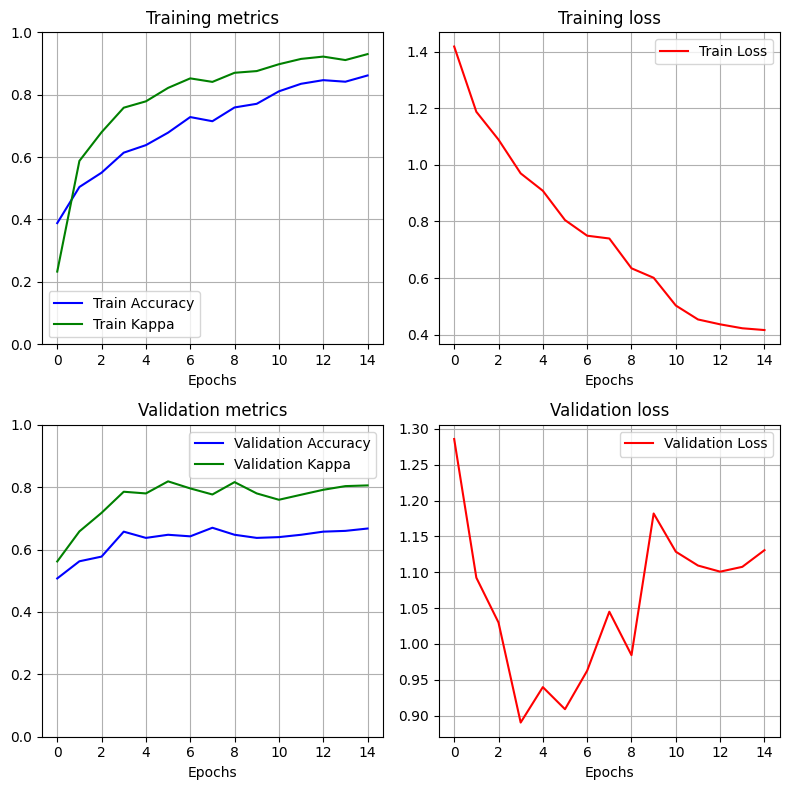

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    gaussian_blur(),
    SLORandomPad((224, 224)),
    FundRandomRotate(prob=0.5, degree=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.3, 0.9)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    CutOut(24),
    #WhiteNoise()
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    gaussian_blur(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

num_epochs=15
name='densenet_gblur.pth'
model=DenseNet()
model=train_and_evaluate(model,transform_train,transform_test,name,f'./{name}/{name}')
#torch.save(model.state_dict(),f'./{name}/{name}')

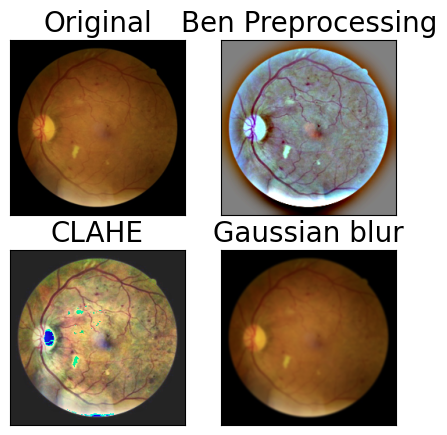

In [ ]:
# visualize
fig,axs=plt.subplots(2,2,figsize=(5,5))
axs=axs.flatten()
sample_path = 'prova.jpg'
orimg=plt.imread(sample_path)
orimg=transforms.Resize((224,224))(Image.fromarray(orimg))
orimg=np.array(orimg)

noise=gaussian_blur()
ben=ben_preprocess()
histeq=clahe()

#original
axs[0].imshow(orimg)
axs[0].set_title("Original", fontsize=20)

orimg=Image.fromarray(orimg)

#slorp
axs[1].imshow(ben(orimg))
axs[1].set_title("Ben Preprocessing", fontsize=20)

#rotate
axs[2].imshow(histeq(orimg))
axs[2].set_title("CLAHE", fontsize=20)

#horflip
axs[3].imshow(noise(orimg))
axs[3].set_title("Gaussian blur", fontsize=20)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

### GRADCAM

Layer 16 in the 4th dense block. It is one of the last layers of the backbone, thus it contains high level features.

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import cv2
from PIL import Image

# Define a hook to capture gradients
class GradCAMHook:
    def __init__(self):
        self.gradients = None
        self.activations = None

    def forward_hook(self, module, input, output):
        self.activations = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

# Load the model
model=DenseNet()
statedict=torch.load('densenet_benpp.pth',map_location=torch.device('cpu'))
model.load_state_dict(statedict)

model.eval()

# Preprocess the image
image_path = "prova.jpg"
image = Image.open(image_path).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = transform(image).unsqueeze(0)

# Hook setup for the target layer
target_layer = model.backbone.features.denseblock4.denselayer16
hook = GradCAMHook()
target_layer.register_forward_hook(hook.forward_hook)
target_layer.register_backward_hook(hook.backward_hook)

# Forward pass
output = model(input_tensor)
predicted_class = output.argmax(dim=1).item()

# Backward pass
target = output[0, predicted_class]
model.zero_grad()  # Clear gradients before backward pass
target.backward()

# Get gradients and activations from the hook
gradients = hook.gradients
activations = hook.activations

# Compute Grad-CAM
weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
cam = F.relu(torch.sum(weights * activations, dim=1)).squeeze().cpu().detach().numpy()

# Normalize and overlay on the image
cam = (cam - cam.min()) / (cam.max() - cam.min())
cam = cv2.resize(cam, (image.size[0], image.size[1]))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
#heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
overlay = cv2.addWeighted(np.array(image), 0.5, heatmap, 0.5, 0)

# Save or display the image
output_path = "gradcam_result.jpg"
cv2.imwrite(output_path, overlay)
print(f"Grad-CAM result saved at {output_path}")


<ipython-input-18-121048a607a9>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  statedict=torch.load('densenet_benpp.pth',map_location=torch.device('cpu'))
/usr/local/lib/

Grad-CAM result saved at gradcam_result.jpg


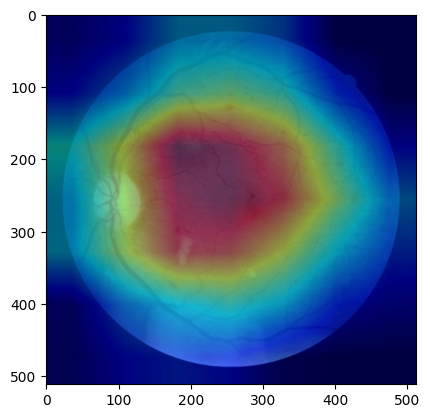

In [ ]:
img=plt.imread('gradcam_result.jpg')
plt.imshow(img)

Here we focus on the 4th block, which is the last one, containing 16 dense layers. The areas higlighted in the image are similar.

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import cv2
from PIL import Image

# Define a hook to capture gradients
class GradCAMHook:
    def __init__(self):
        self.gradients = None
        self.activations = None

    def forward_hook(self, module, input, output):
        self.activations = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

# Load the model
model.eval()  # Set the model to evaluation mode

# Preprocess the image
image_path = "prova.jpg"
image = Image.open(image_path).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = transform(image).unsqueeze(0)

# Hook setup for the target layer
target_layer = model.backbone.features.denseblock4
hook = GradCAMHook()
target_layer.register_forward_hook(hook.forward_hook)
target_layer.register_backward_hook(hook.backward_hook)

# Forward pass
output = model(input_tensor)
predicted_class = output.argmax(dim=1).item()

# Backward pass
target = output[0, predicted_class]
model.zero_grad()  # Clear gradients before backward pass
target.backward()

# Get gradients and activations from the hook
gradients = hook.gradients  # Gradients from the backward pass
activations = hook.activations  # Activations from the forward pass

# Compute Grad-CAM
weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
cam = F.relu(torch.sum(weights * activations, dim=1)).squeeze().cpu().detach().numpy()

# Normalize and overlay on the image
cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalize to [0, 1]
cam = cv2.resize(cam, (image.size[0], image.size[1]))  # Resize to match input image
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # Apply colormap
overlay = cv2.addWeighted(np.array(image), 0.5, heatmap, 0.5, 0)

# Save or display the image
output_path = "gradcam_result.jpg"
cv2.imwrite(output_path, overlay)
print(f"Grad-CAM result saved at {output_path}")

Grad-CAM result saved at gradcam_result.jpg


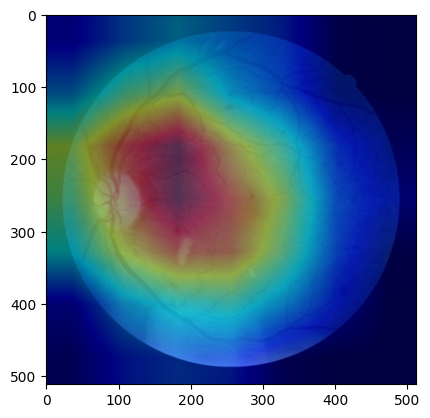

In [ ]:
img=plt.imread('gradcam_result.jpg')
plt.imshow(img)

Here we focus on the transition layer between the 3rd and the 4th block. The areas highlighted are different than in the 4th block. There is a stronger focus on the fovea and the macula, while in the right side of the image there is not a strong focus.

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import cv2
from PIL import Image

# Define a hook to capture gradients
class GradCAMHook:
    def __init__(self):
        self.gradients = None
        self.activations = None

    def forward_hook(self, module, input, output):
        self.activations = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]


model.eval()  # Set the model to evaluation mode

# Preprocess the image
image_path = "prova.jpg"
image = Image.open(image_path).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = transform(image).unsqueeze(0)

# Hook setup for the target layer
target_layer = model.backbone.features.transition3.conv
hook = GradCAMHook()
target_layer.register_forward_hook(hook.forward_hook)
target_layer.register_backward_hook(hook.backward_hook)

# Forward pass
output = model(input_tensor)
predicted_class = output.argmax(dim=1).item()

# Backward pass
target = output[0, predicted_class]
model.zero_grad()  # Clear gradients before backward pass
target.backward()

# Get gradients and activations from the hook
gradients = hook.gradients  # Gradients from the backward pass
activations = hook.activations  # Activations from the forward pass

# Compute Grad-CAM
weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
cam = F.relu(torch.sum(weights * activations, dim=1)).squeeze().cpu().detach().numpy()

# Normalize and overlay on the image
cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalize to [0, 1]
cam = cv2.resize(cam, (image.size[0], image.size[1]))  # Resize to match input image
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # Apply colormap
overlay = cv2.addWeighted(np.array(image), 0.5, heatmap, 0.5, 0)

# Save or display the image
output_path = "gradcam_result.jpg"
cv2.imwrite(output_path, overlay)
print(f"Grad-CAM result saved at {output_path}")

Grad-CAM result saved at gradcam_result.jpg


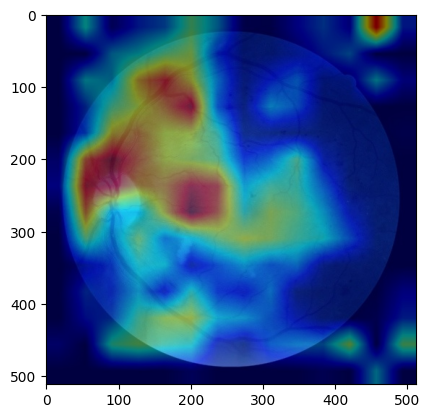

In [ ]:
img=plt.imread('gradcam_result.jpg')
plt.imshow(img)

This layer is located in the transition between the 2nd and the 3rd block. It contains lower level features. The highlighted areas, however, are similar to the ones in the last block.

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import cv2
from PIL import Image

# Define a hook to capture gradients
class GradCAMHook:
    def __init__(self):
        self.gradients = None
        self.activations = None

    def forward_hook(self, module, input, output):
        self.activations = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]


model.eval()  # Set the model to evaluation mode

# Preprocess the image
image_path = "prova.jpg"
image = Image.open(image_path).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = transform(image).unsqueeze(0)

# Hook setup for the target layer
target_layer = model.backbone.features.norm5
hook = GradCAMHook()
target_layer.register_forward_hook(hook.forward_hook)
target_layer.register_backward_hook(hook.backward_hook)

# Forward pass
output = model(input_tensor)
predicted_class = output.argmax(dim=1).item()

# Backward pass
target = output[0, predicted_class]
model.zero_grad()  # Clear gradients before backward pass
target.backward()

# Get gradients and activations from the hook
gradients = hook.gradients  # Gradients from the backward pass
activations = hook.activations  # Activations from the forward pass

# Compute Grad-CAM
weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
cam = F.relu(torch.sum(weights * activations, dim=1)).squeeze().cpu().detach().numpy()

# Normalize and overlay on the image
cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalize to [0, 1]
cam = cv2.resize(cam, (image.size[0], image.size[1]))  # Resize to match input image
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # Apply colormap
overlay = cv2.addWeighted(np.array(image), 0.5, heatmap, 0.5, 0)

# Save or display the image
output_path = "gradcam_result.jpg"
cv2.imwrite(output_path, overlay)
print(f"Grad-CAM result saved at {output_path}")

Grad-CAM result saved at gradcam_result.jpg


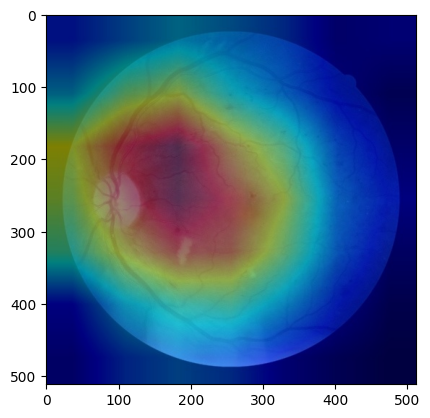

In [ ]:
img=plt.imread('gradcam_result.jpg')
plt.imshow(img)

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import cv2
from PIL import Image

# Define a hook to capture gradients
class GradCAMHook:
    def __init__(self):
        self.gradients = None
        self.activations = None

    def forward_hook(self, module, input, output):
        self.activations = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]


model.eval()  # Set the model to evaluation mode

# Preprocess the image
image_path = "prova.jpg"
image = Image.open(image_path).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = transform(image).unsqueeze(0)

# Hook setup for the target layer
target_layer = model.backbone.features.denseblock1

hook = GradCAMHook()
target_layer.register_forward_hook(hook.forward_hook)
target_layer.register_backward_hook(hook.backward_hook)

# Forward pass
output = model(input_tensor)
predicted_class = output.argmax(dim=1).item()

# Backward pass
target = output[0, predicted_class]
model.zero_grad()  # Clear gradients before backward pass
target.backward()

# Get gradients and activations from the hook
gradients = hook.gradients  # Gradients from the backward pass
activations = hook.activations  # Activations from the forward pass

# Compute Grad-CAM
weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
cam = F.relu(torch.sum(weights * activations, dim=1)).squeeze().cpu().detach().numpy()

# Normalize and overlay on the image
cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalize to [0, 1]
cam = cv2.resize(cam, (image.size[0], image.size[1]))  # Resize to match input image
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # Apply colormap
overlay = cv2.addWeighted(np.array(image), 0.5, heatmap, 0.5, 0)

# Save or display the image
output_path = "gradcam_result.jpg"
cv2.imwrite(output_path, overlay)
print(f"Grad-CAM result saved at {output_path}")

Grad-CAM result saved at gradcam_result.jpg


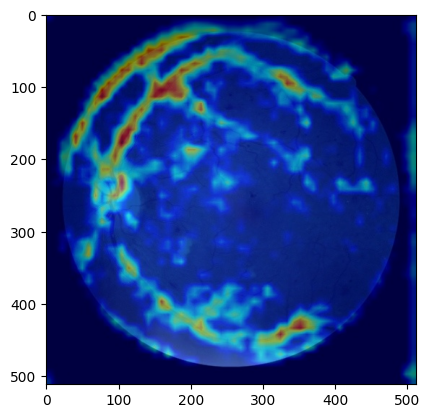

In [ ]:
img=plt.imread('gradcam_result.jpg')
plt.imshow(img)